# **Two Kinects - K1 for X and K2 for Y**

## **Install Libraries**

In [ ]:
!pip install librosa

## **Path configuration**

In [ ]:
k1_path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K1'
k2_path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K2'
k1and2_path = '/content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K1 and K2'

k1_labeled_coors = '/k1-labeled_coores'
k2_labeled_coors = '/k2-labeled_coores'
k1_ground = '/k1-Ground'
k2_ground = '/k2-Ground'
k1_table = '/k1-Table'
k2_table = '/k2-Table'
k1_ref = '/k1-ref'
k2_ref = '/k2-ref'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **GCC-PHAT Algorithm**

In [ ]:
def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=10):

    # Get summation of the shapes of two signals
    n = np.shape(sig)[0] + np.shape(refsig)[0]

    # applies hanning window before DRFFT (discrete real fast fourier transform)
    window = np.hanning(len(sig))

    # applies FFT on both signals and gets the cross power spectral density (CPSD)
    SIG = np.fft.rfft(sig*window, n=n)
    REFSIG = np.fft.rfft(refsig*window, n=n)
    G = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(G / np.abs(G), n=(interp * n))

    # where to shift xcorr graph to get negative tau
    shift = int(interp * n / 2)

    if max_tau:
        shift = np.minimum(int(interp * fs * max_tau), shift)

    cc = np.concatenate((cc[-shift:], cc[:shift + 1]))

    # find max cross correlation index
    argmax = np.argmax(cc) - shift

    tau = argmax / float(interp * fs)
    return tau, cc

## **Surface Prediction**

In [ ]:
def seperate_channels(path):
    # Read the multi-channel audio file
    sample_rate, data = wav.read(path)

    # get the number of channels
    num_channels = data.shape[1]

    channels = []
    # Extract each channel and save as a separate file
    for i in range(num_channels):
        channel_data = data[:, i]
        channels.append(channel_data)
    return channels, sample_rate

def calc_tdoas(path):
    [ch0, ch1, ch2, ch3], sr = seperate_channels(path)

    tdoa01, cc = gcc_phat(ch0, ch1, sr)
    tdoa02, cc = gcc_phat(ch0, ch2, sr)
    tdoa03, cc = gcc_phat(ch0, ch3, sr)
    tdoa12, cc = gcc_phat(ch1, ch2, sr)
    tdoa13, cc = gcc_phat(ch1, ch3, sr)
    tdoa23, cc = gcc_phat(ch2, ch3, sr)
    tdoas = {
            'tdoa01': tdoa01,
            'tdoa02': tdoa02,
            'tdoa03': tdoa03,
            'tdoa12': tdoa12,
            'tdoa13': tdoa13,
            'tdoa23': tdoa23
    }
    return tdoas

# Function to load audio files and calculate tdoas
def load_and_calc_tdoas(folder1, folder2):
    data = []
    for label, folder in folder1.items():
        for file_name in os.listdir(folder):
            if (file_name.endswith(".m4a") or file_name.endswith(".wav")):
                file_path1 = os.path.join(folder1[label], file_name)
                file_path2 = os.path.join(folder2[label], file_name)
                try:
                    tdoas1 = calc_tdoas(file_path1)
                    tdoas2 = calc_tdoas(file_path2)
                    combined_tdoas = {**tdoas1, **{f"{key}_2": value for key, value in tdoas2.items()}}
                    combined_tdoas['label'] = label
                    data.append(combined_tdoas)
                except Exception as e:
                    print(f"Error processing {file_path1} and {file_path2}: {e}")
    return pd.DataFrame(data)

In [ ]:
# Function to extract features from an audio signal
def extract_features(y, sr):
    features = {}
    features['chroma_stft'] = librosa.feature.chroma_stft(y=y, sr=sr).mean()
    features['rmse'] = librosa.feature.rms(y=y).mean()
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    features['rolloff'] = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    features['zero_crossing_rate'] = librosa.feature.zero_crossing_rate(y).mean()
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(1, 14):
        features[f'mfcc{i}'] = mfccs[i-1].mean()
    return features

In [ ]:
# Paths to the folders
k1_folders = {
    "Table": k1_path + k1_table,
    "Ground": k1_path + k1_ground
}

# Paths to the folders
k2_folders = {
    "Table": k2_path + k2_table,
    "Ground": k2_path + k2_ground
}

In [ ]:
import os
import audioread
import librosa
import scipy.io.wavfile as wav
import pandas as pd
import numpy as np

# Function to load audio files and extract features
def load_and_extract_features(folder1, folder2):
    data = []
    for label, folder in folder1.items():
        for file_name in os.listdir(folder):
            if file_name.endswith(".m4a") or file_name.endswith(".wav"):
                file_path1 = os.path.join(folder1[label], file_name)
                file_path2 = os.path.join(folder2[label], file_name)
                try:
                    with audioread.audio_open(file_path1) as input_file1, audioread.audio_open(file_path2) as input_file2:
                        y1, sr1 = librosa.load(input_file1, sr=None)
                        y2, sr2 = librosa.load(input_file2, sr=None)
                        features1 = extract_features(y1, sr1)
                        features2 = extract_features(y2, sr2)
                        # Combine features into a single dictionary
                        combined_features = {**features1, **{f"{key}_2": value for key, value in features2.items()}}
                        combined_features['label'] = label
                        data.append(combined_features)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return pd.DataFrame(data)

In [ ]:
# Extract features and save to CSV
data = load_and_extract_features(k1_folders, k2_folders)
tdoas = load_and_calc_tdoas(k1_folders, k2_folders)
tdoas = tdoas.drop('label', axis=1)
data = data.join(tdoas)
data.to_csv(k1and2_path + '/k1and2_audio_features.csv', index=False)

In [ ]:
print(data.shape)
print(data.columns)

(119, 51)
Index(['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'chroma_stft_2', 'rmse_2', 'spectral_centroid_2',
       'spectral_bandwidth_2', 'rolloff_2', 'zero_crossing_rate_2', 'mfcc1_2',
       'mfcc2_2', 'mfcc3_2', 'mfcc4_2', 'mfcc5_2', 'mfcc6_2', 'mfcc7_2',
       'mfcc8_2', 'mfcc9_2', 'mfcc10_2', 'mfcc11_2', 'mfcc12_2', 'mfcc13_2',
       'label', 'tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23',
       'tdoa01_2', 'tdoa02_2', 'tdoa03_2', 'tdoa12_2', 'tdoa13_2', 'tdoa23_2'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Load the CSV file
data = pd.read_csv(k1and2_path + '/k1and2_audio_features.csv')

# Prepare the data
X = data.drop('label', axis=1)
y = data['label']

# Encode labels
label_encoder_surface = LabelEncoder()
y = label_encoder_surface.fit_transform(y)

# Split data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler_surface = StandardScaler()
X_train = scaler_surface.fit_transform(X_train)
X_test = scaler_surface.transform(X_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(95, 50)
(95,)


Random Forest Test Accuracy: 95.83%
              precision    recall  f1-score   support

      Ground       1.00      0.93      0.97        15
       Table       0.90      1.00      0.95         9

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24



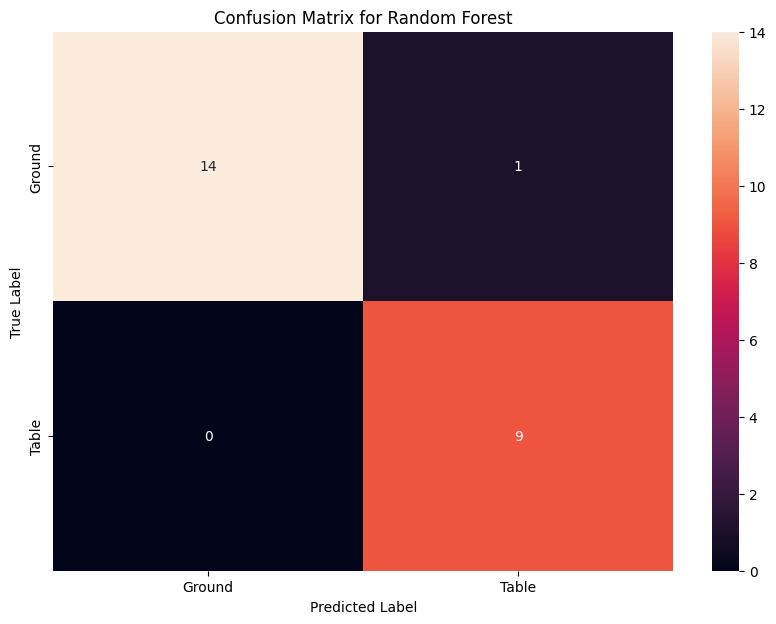

Gradient Boosting Test Accuracy: 91.67%
              precision    recall  f1-score   support

      Ground       0.93      0.93      0.93        15
       Table       0.89      0.89      0.89         9

    accuracy                           0.92        24
   macro avg       0.91      0.91      0.91        24
weighted avg       0.92      0.92      0.92        24



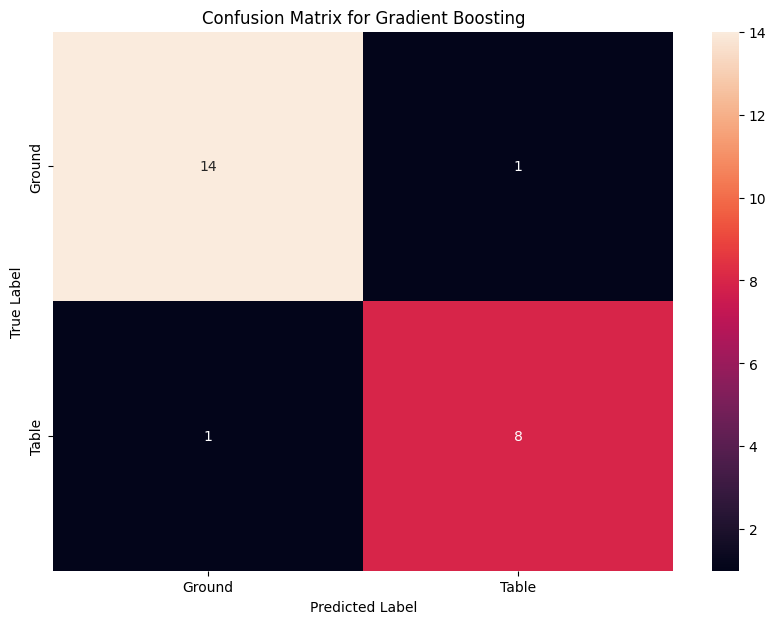

SVM Test Accuracy: 95.83%
              precision    recall  f1-score   support

      Ground       1.00      0.93      0.97        15
       Table       0.90      1.00      0.95         9

    accuracy                           0.96        24
   macro avg       0.95      0.97      0.96        24
weighted avg       0.96      0.96      0.96        24



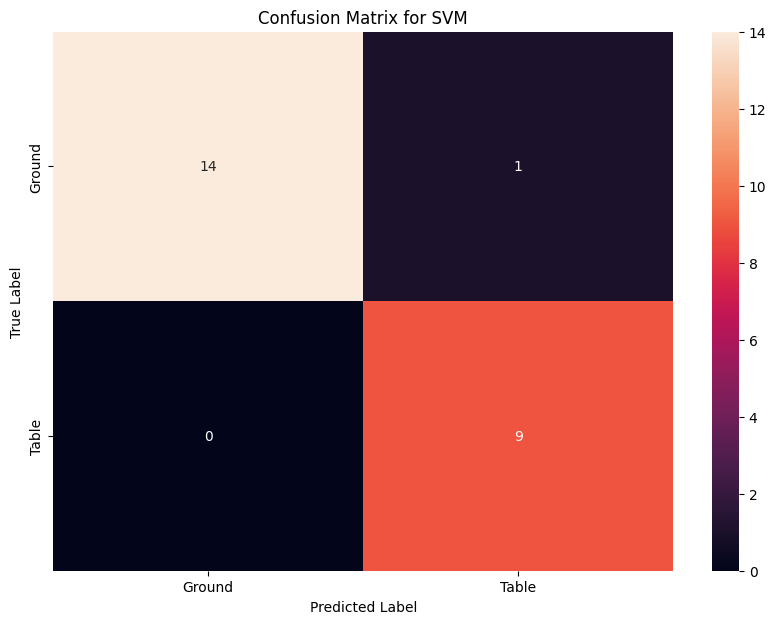

XGBoost Test Accuracy: 87.50%
              precision    recall  f1-score   support

      Ground       0.93      0.87      0.90        15
       Table       0.80      0.89      0.84         9

    accuracy                           0.88        24
   macro avg       0.86      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24



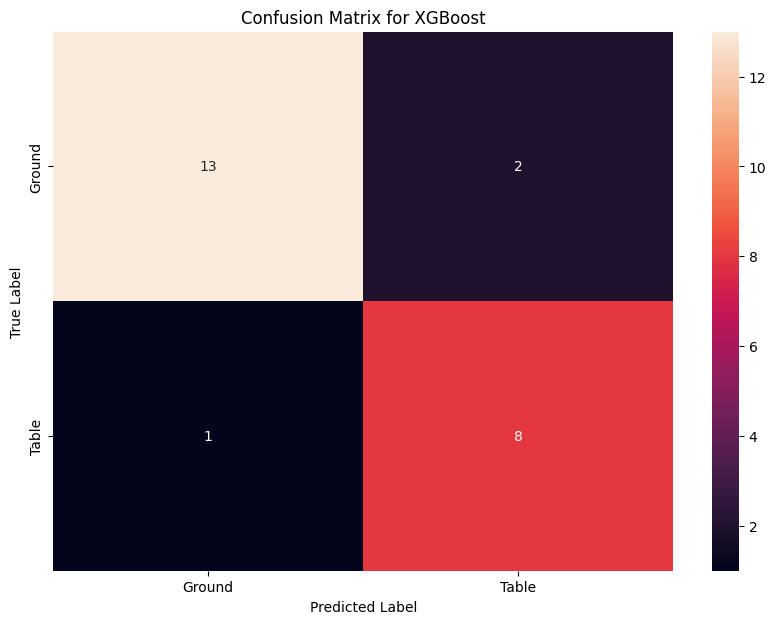

In [ ]:
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Model training and evaluation
surface_models = {
    "Random Forest": RandomForestClassifier(n_estimators=150, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=2, learning_rate=1, objective='binary:logistic')
}

for model_name, model in surface_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy*100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=label_encoder_surface.classes_))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder_surface.classes_, yticklabels=label_encoder_surface.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

### **Fine Tune the Surface Prediction Model**

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.77
Random Forest Test Accuracy after tuning: 87.50%
              precision    recall  f1-score   support

      Ground       0.93      0.87      0.90        15
       Table       0.80      0.89      0.84         9

    accuracy                           0.88        24
   macro avg       0.86      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24



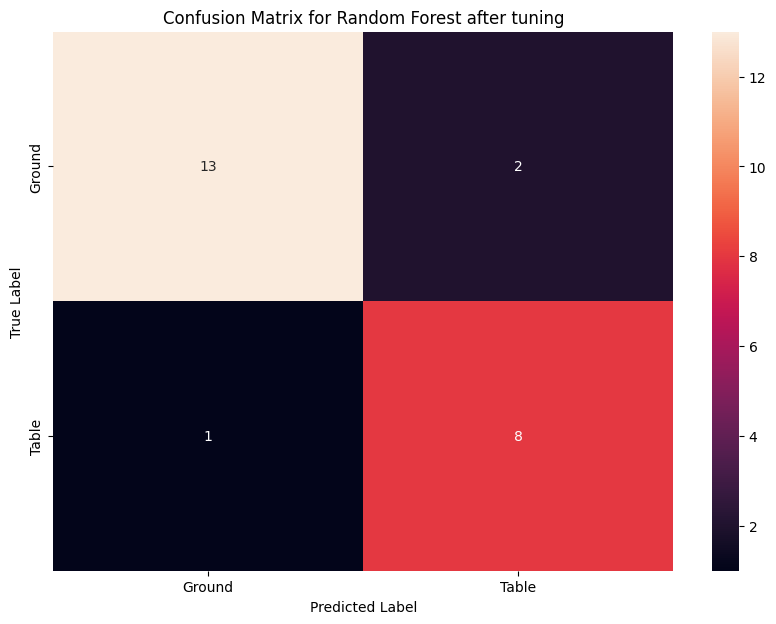

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Fine tuning the random forsest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=surface_models["Random Forest"], param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters for Random Forest: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

# Use the best estimator to predict the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest Test Accuracy after tuning: {accuracy*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest after tuning')
plt.show()

In [ ]:
import os
import audioread
import librosa
import scipy.io.wavfile as wav
import pandas as pd

# Function to load and preprocess a new audio file
def predict_new_audio_surface(file_path, model, scaler, label_encoder):
    try:
        with audioread.audio_open(file_path) as input_file:
            y, sr = librosa.load(input_file, sr=None)
            features = extract_features(y, sr)
            tdoas = calc_tdoas(file_path)
            features.update(tdoas)
            features_df = pd.DataFrame([features])

            features_scaled = scaler.transform(features_df)
            prediction = model.predict(features_scaled)
            predicted_label = label_encoder.inverse_transform(prediction)
            return predicted_label[0]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

### **Get models Accuracies (Not neccessary)**

In [ ]:
def surface_accuracy(sample_folder, models, fine_model=None):
    accuracies = {}
    for model_name, model in models.items():
        actual_surfaces = []
        predicted_surfaces = []
        for file_name in os.listdir(sample_folder):
            if file_name.endswith(".m4a") or file_name.endswith(".wav"):
                file_path = os.path.join(sample_folder, file_name)
                try:
                    predicted_surface = predict_new_audio_surface(file_path, model, scaler, label_encoder)
                    actual_pos = extract_numbers(file_name)
                    actual_surface = determine_actual_surface(actual_pos[1], table_start, table_end)
                    if predicted_surface == 'Box':
                        predicted_surface = 'Table'
                    predicted_surfaces.append(predicted_surface)
                    actual_surfaces.append(actual_surface)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    return
        accuracy = accuracy_score(actual_surfaces, predicted_surfaces)
        accuracies[model_name] = accuracy
    return accuracies

# models['fine_tuned_rf'] = best_rf_model
accuracies = surface_accuracy(sample_folder, models)
print(accuracies)

NameError: name 'models' is not defined

In [ ]:
print(accuracies)

{'Random Forest': 0.9803921568627451, 'Gradient Boosting': 1.0, 'SVM': 1.0, 'XGBoost': 1.0}


### **Determine Surface Prediction Model**

In [ ]:
surface_prediction_model = surface_models['Random Forest']
# surface_prediction_model = best_rf_model
print(surface_prediction_model)

RandomForestClassifier(n_estimators=150, random_state=42)


#### **Results for Training the surface prediction models:**

Runing on the sample folder dataset at /content/drive/MyDrive/Taarlab/Classical/Main/Datasetnew/Samples, here are the obtained accuracies of the model:

* **TDOA values included:** In this case, the maximum accuraccy obtained was **77%** which belongs to the random forest model. Although fine-tunning was applied, not much change was seen in the obtained accuracy. These are the results among the performance of four models containing an XGBoost model, an SVM model, and two random forest models one with fine-tunning and one under ordinary conditions.

* **TDOA values included:** In this case, the maximum accuracy obtained was **70%** belonging to the two random forest models and the SVM model jointly.

Thus, the model that we'll be using will be the random forest trained on the dataset containing the TDOA values. Along the TDOA values, 19 other features are used as well for classifying the surface that the ball hits. There are 142 samples in the classification sample folder which the ratio of 0.2 of them were used for the test data. The obtained test accuracy on these test data were 100% max. The obtained accuracies above belong to the accuracy of the prediction of the model on the sample data gathered in the folder mentioned above.

One important factor to be considered is that having more samples plays a sigbifact role on this models' performances. Thus, having more samples is assumed to generate even higher accuracies for the surface prediction model. In the next step, the samples at the sample folder above will be included in the train and test datasets of the model as well.

Also, it is worthy to note that these results are obtained using one kinnect having 4 microphones being located at [76.6, 0, 75], [61.7, 0, 75], [57.7, 0, 75], [54, 0, 75] respectively.

## **Signal Processing**

In [ ]:
import librosa

def signal_load_and_preprocess(path1, path2, path3):
    sig1, sr1 = librosa.load(path1, sr=None)
    sig2, sr2 = librosa.load(path2, sr=None)
    sig3, sr3 = librosa.load(path3, sr=None)

    sig2 = librosa.resample(sig2, orig_sr=sr2, target_sr=sr1)
    sig3 = librosa.resample(sig3, orig_sr=sr3, target_sr=sr1)

    min_shape = min(sig1.shape[0], sig2.shape[0], sig3.shape[0])
    sig1 = sig1[:min_shape]
    sig2 = sig2[:min_shape]
    sig3 = sig3[:min_shape]

    print('-->Load & Preprocessing Done.')
    return sig1, sig2, sig3, sr1

In [ ]:
import scipy.io.wavfile as wav
import numpy as np

def load_and_seperate_channels(path):
    # Read the multi-channel audio file
    sample_rate, data = wav.read(path)

    # Check the number of channels
    num_channels = data.shape[1]

    channels = []
    # Extract each channel and save as a separate file
    for i in range(num_channels):
        channel_data = data[:, i]
        channels.append(channel_data)

    return channels, sample_rate

In [ ]:
import re

def extract_numbers(file_name):
    numbers = re.findall(r'\d+', file_name)
    numbers = list(map(int, numbers))
    if numbers[2] == 75:
        numbers[2] = 74
    return numbers

def determine_actual_surface(y, table_start, table_end):
    if y < table_start:
        return 'Ground'
    else:
        if table_start <= y <= table_end:
            return 'Table'

In [ ]:
table_start = 330
table_end = 400

sample_folder = k2_path + k2_labeled_coors
sample_name = '/277-5-0.wav'
sample_path = sample_folder + sample_name
actual_pos = extract_numbers(sample_name)
actual_surface = determine_actual_surface(actual_pos[1], table_start, table_end)

[ch0, ch1, ch2, ch3], sr = load_and_seperate_channels(sample_path)

In [ ]:
tdoa01, cc = gcc_phat(ch0, ch1, sr)
tdoa02, cc = gcc_phat(ch0, ch2, sr)
tdoa03, cc = gcc_phat(ch0, ch3, sr)
tdoa12, cc = gcc_phat(ch1, ch2, sr)
tdoa13, cc = gcc_phat(ch1, ch3, sr)
tdoa23, cc = gcc_phat(ch2, ch3, sr)

tdoas = {
        'tdoa01': [tdoa01],
        'tdoa02': [tdoa02],
        'tdoa03': [tdoa03],
        'tdoa12': [tdoa12],
        'tdoa13': [tdoa13],
        'tdoa23': [tdoa23]
}

print('Estimated TDOAs:', tdoas)

Estimated TDOAs: {'tdoa01': [0.00039375], 'tdoa02': [0.0005125], 'tdoa03': [0.00060625], 'tdoa12': [9.375e-05], 'tdoa13': [0.00019375], 'tdoa23': [8.125e-05]}


## **Actual TDOAs**

In [ ]:
import math

k2_mic_pos = [
        [282, 211.3, 75],
        [282, 196.4, 75],
        [282, 192.4, 75],
        [282, 188.7, 75]
    ]

k1_mic_pos = [
        [152.3, 0, 77],
        [137.4, 0, 75],
        [133.4, 0, 74],
        [129.7, 0, 74]
    ]

def tdoas_calc(pos, tdoas, k2=False):
    x, y, z = pos

    mic_pos = k1_mic_pos
    if k2:
        mic_pos = k2_mic_pos

    distances = []
    for i in range(0, 4):
        distances.append(math.sqrt((x - mic_pos[i][0])**2 + (y - mic_pos[i][1])**2 + (z - mic_pos[i][2])**2))

    toas = []
    for i in range(0, 4):
        toas.append(distances[i] / 34300)

    cal_tdoas = {
        'tdoa01': [toas[0] - toas[1]],
        'tdoa02': [toas[0] - toas[2]],
        'tdoa03': [toas[0] - toas[3]],
        'tdoa12': [toas[1] - toas[2]],
        'tdoa13': [toas[1] - toas[3]],
        'tdoa23': [toas[2] - toas[3]]
    }

    # Calculate TDOA error
    error = 0
    for act, val in zip(cal_tdoas.values(), tdoas.values()):
        error += abs((val[0] - act[0]))

    return cal_tdoas, error

# tdoas_act, tdoa_error = tdoas_calc(actual_pos, tdoas, k2=True)
# print('Actual Position:', actual_pos)
# print('Actual TDOAs:', tdoas_act)
# print('Measured TDOAs:', tdoas)
# print(f'TDOA Error: {tdoa_error:.16f}')

## **TDOA refinement**

In [ ]:
k2_mic_pos = [
        [282, 211.3, 75],
        [282, 196.4, 75],
        [282, 192.4, 75],
        [282, 188.7, 75]
    ]

k1_mic_pos = [
    [152.3, 0, 77],
    [137.4, 0, 75],
    [133.4, 0, 74],
    [129.7, 0, 74]
]

In [ ]:
# folder_path = sample_folder
folder_path = k1_path + k1_ref

In [ ]:
import os
import math

def calc_actual_tdoa(pos):
    x, y, z = pos
    mic_pos = k1_mic_pos

    distances = []
    for i in range(0, 4):
        distances.append(math.sqrt((x - mic_pos[i][0])**2 + (y - mic_pos[i][1])**2 + (z - mic_pos[i][2])**2))
    toas = []
    for i in range(0, 4):
        toas.append(distances[i] / 34300)
    cal_tdoas = {
        'tdoa01': toas[0] - toas[1],
        'tdoa02': toas[0] - toas[2],
        'tdoa03': toas[0] - toas[3],
        'tdoa12': toas[1] - toas[2],
        'tdoa13': toas[1] - toas[3],
        'tdoa23': toas[2] - toas[3]
    }
    return cal_tdoas

def calculate_actual_TDOAs(folder_path):
    actuals = {
        'tdoa01': [],
        'tdoa02': [],
        'tdoa03': [],
        'tdoa12': [],
        'tdoa13': [],
        'tdoa23': []
    }
    poses = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".m4a") or file_name.endswith(".wav"):
            actual_pos = extract_numbers(file_name)[:3]
            actual_tdoa = calc_actual_tdoa(actual_pos)
        for tdoa_name, tdoa_val in actual_tdoa.items():
            actuals[tdoa_name].append(tdoa_val)
        poses.append(actual_pos)

    return actuals, poses

actuals_tdoas, poses = calculate_actual_TDOAs(folder_path)
for name, val_list in actuals_tdoas.items():
    print(name + ':')
    print(val_list)
print('Number of Samples:', len(actuals_tdoas['tdoa01']))
print(poses)

tdoa01:
[0.0003187078627291291, 0.0002628975038788733, 0.00016240501425948206, 4.992540954633145e-05, 5.506547331904149e-05, 7.527891837301286e-05, -0.00010487972354465604, -0.00014623569468434627, -0.00026314517051184835, -0.0002229134832048411, 0.0001974641809737339, 0.00011262202741617756, 2.7294109028463097e-05, 2.287329919706607e-05, -0.00021217536808261495, 0.00015131630777415368, 0.0001069284386596512, 2.0230620284946224e-05, -2.0510350433749353e-05, -8.635611379733711e-05, -0.0001235019550172127, 5.675071653648764e-05, 0.00024132694632673316, 0.00013916946942831541, 8.35134747911876e-05, 4.5986494152243027e-05, -5.372421191661772e-05, 1.9292727964734246e-05, -1.898966488112462e-05, -5.682968562579875e-05, -7.71977545453717e-05, 7.783016064460795e-05, 2.8647362205189153e-05, -6.94434253965745e-05, 4.388920908532726e-05, 5.641796820670883e-06, -3.276071411982204e-05]
tdoa02:
[0.00040822198590554455, 0.0003369938065729207, 0.0002063376052718704, 6.239168721710285e-05, 6.8843656439

In [ ]:
def get_measured_TDOAS(folder_path):
    measured_vals = {
        'tdoa01': [],
        'tdoa02': [],
        'tdoa03': [],
        'tdoa12': [],
        'tdoa13': [],
        'tdoa23': []
    }
    poses = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".m4a") or file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            actual_pos = extract_numbers(file_name)[:3]
            [ch0, ch1, ch2, ch3], sr = load_and_seperate_channels(file_path)
            tdoa01, cc = gcc_phat(ch0, ch1, sr)
            tdoa02, cc = gcc_phat(ch0, ch2, sr)
            tdoa03, cc = gcc_phat(ch0, ch3, sr)
            tdoa12, cc = gcc_phat(ch1, ch2, sr)
            tdoa13, cc = gcc_phat(ch1, ch3, sr)
            tdoa23, cc = gcc_phat(ch2, ch3, sr)
            tdoas = {
                    'tdoa01': tdoa01,
                    'tdoa02': tdoa02,
                    'tdoa03': tdoa03,
                    'tdoa12': tdoa12,
                    'tdoa13': tdoa13,
                    'tdoa23': tdoa23
            }
            for tdoa_name, tdoa_val in tdoas.items():
                measured_vals[tdoa_name].append(tdoa_val)
            poses.append(actual_pos)

    return measured_vals, poses


measured_tdoas, measured_poses = get_measured_TDOAS(folder_path)
for name, val_list in measured_tdoas.items():
    print(name + ':')
    print(val_list)
print('Number of Samples:', len(measured_tdoas['tdoa01']))
print(measured_poses)

tdoa01:
[0.000275, 0.00020625, 0.0001375, 2.5e-05, 2.5e-05, 1.25e-05, -0.000175, -0.0002, -0.00031875, -0.0002375, 0.00018125, 9.375e-05, 3.125e-05, 2.5e-05, -0.0002, 0.0001125, 9.375e-05, 3.125e-05, -1.25e-05, -6.25e-05, -7.5e-05, -0.00015625, 0.00021875, 0.00011875, 9.375e-05, 5.625e-05, -1.875e-05, 3.75e-05, 6.25e-06, -1.875e-05, -3.75e-05, 8.75e-05, 5e-05, -3.125e-05, 5.625e-05, 2.5e-05, 0.0]
tdoa02:
[0.00034375, 0.00025, 0.0001625, 1.25e-05, 1.25e-05, 6.25e-06, -0.00021875, -0.00024375, -0.0004, -0.00030625, 0.000225, 0.00011875, 3.125e-05, 1.875e-05, -0.0002625, 0.0001, 0.000125, 3.125e-05, -1.875e-05, -8.75e-05, -0.0001, -0.00020625, 0.000275, 0.00015, 0.000125, 6.875e-05, -2.5e-05, 4.375e-05, 6.25e-06, -3.125e-05, -5e-05, 0.00010625, 5.625e-05, -4.375e-05, 6.875e-05, 3.125e-05, -6.25e-06]
tdoa03:
[0.00040625, 0.0002875, 0.00018125, 6.25e-06, 6.25e-06, -1.25e-05, -0.000275, -0.00030625, -0.000475, -0.00038125, 0.0002625, 0.00013125, 2.5e-05, 1.25e-05, -0.000325, 0.0001, 0.000162

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

df = pd.DataFrame(measured_tdoas)
df_actual = pd.DataFrame(actuals_tdoas)
ref_models = {}
for tdoa in ['tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23']:
    ref_models[tdoa] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42, loss='absolute_error')
    # models[tdoa] = LinearRegression()
    # models[tdoa] = SVR(kernel='rbf')
    # models[tdoa] = create_mlp_model(input_dim=1)

# Fit the model for each TDOA separately
for tdoa in ['tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23']:
    # X_ref = df[[tdoa]]
    X_ref = df
    y_ref = df_actual[tdoa].values

    # models[tdoa].fit(X, y, epochs=50, batch_size=20, verbose=1, validation_split=0.2)
    ref_models[tdoa].fit(X_ref, y_ref)

    # Predict the TDOA values
    y_pred = ref_models[tdoa].predict(X_ref)

    # Print the results
    print(f'Regression results for {tdoa}:')
    print(f'Mean absolute error: {mean_absolute_error(y_ref, y_pred)}')
    print(f'R2 score: {r2_score(y_ref, y_pred)}')
    # print(f'Coefficients: {models[tdoa].coef_}')
    # print(f'Intercept: {models[tdoa].intercept_}\n')

Regression results for tdoa01:
Mean absolute error: 1.4331384677087252e-06
R2 score: 0.9986344105799767
Regression results for tdoa02:
Mean absolute error: 1.3897282455626091e-06
R2 score: 0.9990837681302625
Regression results for tdoa03:
Mean absolute error: 9.725556535252847e-07
R2 score: 0.9995294259263461
Regression results for tdoa12:
Mean absolute error: 3.616868582025903e-07
R2 score: 0.9984346827027333
Regression results for tdoa13:
Mean absolute error: 2.715283759581978e-07
R2 score: 0.999840286470233
Regression results for tdoa23:
Mean absolute error: 7.290479368858503e-07
R2 score: 0.9912581930594837


### **Train Neural Network for TDOA Refinement**

In [ ]:
df.to_csv('/content/drive/MyDrive/Taarlab/Classical/Main/regressionfiles/input.csv')
df_actual.to_csv('/content/drive/MyDrive/Taarlab/Classical/Main/regressionfiles/labels.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the data
input_data = df
output_data = df_actual

# Split the data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, random_state=42)

# Normalize the input data
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

results = {}

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

ref_net_models = {}

# Loop through each column
for col in input_data.columns:
    # Get the target column
    y_train_col = y_train[[col]].values
    y_test_col = y_test[[col]].values

    # Normalize the target column
    scaler_y_col = StandardScaler()
    y_train_col = scaler_y_col.fit_transform(y_train_col)
    y_test_col = scaler_y_col.transform(y_test_col)

    # Define the learning rate scheduler
    initial_learning_rate = 0.001

    # Build the deep neural network model
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))  # Output layer for single column prediction

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(X_train, y_train_col, epochs=200, batch_size=32, validation_split=0.1, verbose=1, callbacks=[reduce_lr])

    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test_col, verbose=0)
    y_pred = model.predict(X_test)
    print(X_test)

    # Store the model
    ref_net_models[col] = model

    # Inverse transform the predictions and actual values
    y_pred_inverse = scaler_y_col.inverse_transform(y_pred)
    y_test_col_inverse = scaler_y_col.inverse_transform(y_test_col)

    # Calculate R² score
    r2 = r2_score(y_test_col_inverse, y_pred_inverse)

    # Store results
    results[col] = {
        'loss': loss,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred_inverse,
        'actual': y_test_col_inverse
    }

    print(f'Column: {col}')
    print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}, R² Score: {r2:.4f}')
    print()

# Display results for all columns
for col, metrics in results.items():
    print(f'Column: {col}')
    print(f'Test Loss: {metrics["loss"]:.4f}, Test MAE: {metrics["mae"]:.4f}, R² Score: {metrics["r2"]:.4f}')
    print('Predictions:', metrics['predictions'].flatten())
    print('Actual:', metrics['actual'].flatten())
    print()

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.8983 - mae: 0.8100 - val_loss: 0.6167 - val_mae: 0.7752 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 33ms/step - loss: 0.5541 - mae: 0.6371 - val_loss: 0.2978 - val_mae: 0.5398 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 35ms/step - loss: 0.3232 - mae: 0.4843 - val_loss: 0.1116 - val_mae: 0.3294 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 34ms/step - loss: 0.1714 - mae: 0.3415 - val_loss: 0.0178 - val_mae: 0.1283 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 33ms/step - loss: 0.0805 - mae: 0.2123 - val_loss: 0.0041 - val_mae: 0.0610 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 36ms/step - loss: 0.0445 - mae: 0.1476 - val_loss: 0.0506 - val_mae: 0.2244 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 33ms/step - loss: 0.0497 - mae: 0.1666 - val_loss: 0.1219 - val_mae: 0.3425 - lr: 0.0010
E

1/1 [==============================] - 0s 93ms/step
[[ 0.04815653  0.04984701  0.0687028   0.06759579  0.02701552  0.        ]
 [-1.15794573 -0.42369955 -0.44208758 -1.03324991 -1.08512331 -0.96888347]
 [-0.40933053 -0.45752431 -0.52721931 -0.66630134 -0.65737761 -0.77510678]]
Column: tdoa13
Test Loss: 0.0563, Test MAE: 0.2209, R² Score: 0.7028

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.8852 - mae: 0.7975 - val_loss: 0.4508 - val_mae: 0.6649 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 94ms/step - loss: 0.5309 - mae: 0.6175 - val_loss: 0.1819 - val_mae: 0.4237 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 70ms/step - loss: 0.2953 - mae: 0.4634 - val_loss: 0.0403 - val_mae: 0.2005 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 64ms/step - loss: 0.1458 - mae: 0.3229 - val_loss: 0.0014 - val_mae: 0.0338 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0643 - m

1/1 [==============================] - 0s 75ms/step
[[ 0.04815653  0.04984701  0.0687028   0.06759579  0.02701552  0.        ]
 [-1.15794573 -0.42369955 -0.44208758 -1.03324991 -1.08512331 -0.96888347]
 [-0.40933053 -0.45752431 -0.52721931 -0.66630134 -0.65737761 -0.77510678]]
Column: tdoa23
Test Loss: 0.0686, Test MAE: 0.2479, R² Score: 0.6102

Column: tdoa01
Test Loss: 0.0734, Test MAE: 0.2112, R² Score: 0.7358
Predictions: [ 2.4374551e-05 -1.4670884e-04 -9.9317847e-05]
Actual: [-4.89880722e-06 -2.18673824e-04 -1.03136404e-04]

Column: tdoa02
Test Loss: 0.0478, Test MAE: 0.1700, R² Score: 0.8170
Predictions: [ 1.5563755e-05 -2.1250117e-04 -1.4219360e-04]
Actual: [-2.07599976e-05 -2.83146633e-04 -1.42285276e-04]

Column: tdoa03
Test Loss: 0.0685, Test MAE: 0.2239, R² Score: 0.7218
Predictions: [ 1.1831566e-05 -2.4555012e-04 -1.6613131e-04]
Actual: [-4.07533040e-05 -3.44775285e-04 -1.82492996e-04]

Column: tdoa12
Test Loss: 0.0700, Test MAE: 0.2320, R² Score: 0.6538
Predictions: [-4.63

In [ ]:
print(ref_net_models)

{'tdoa01': <keras.src.engine.sequential.Sequential object at 0x7b0c41ce5d50>, 'tdoa02': <keras.src.engine.sequential.Sequential object at 0x7b0c43417c10>, 'tdoa03': <keras.src.engine.sequential.Sequential object at 0x7b0c43203340>, 'tdoa12': <keras.src.engine.sequential.Sequential object at 0x7b0c435ee8f0>, 'tdoa13': <keras.src.engine.sequential.Sequential object at 0x7b0c4278ed10>, 'tdoa23': <keras.src.engine.sequential.Sequential object at 0x7b0c430bf400>}


### **Specify the Refinement Model**

In [ ]:
regression_models = ref_models
# scaler_ref = scaler_y_col
print(regression_models)

{'tdoa01': GradientBoostingRegressor(loss='absolute_error', max_depth=10, random_state=42), 'tdoa02': GradientBoostingRegressor(loss='absolute_error', max_depth=10, random_state=42), 'tdoa03': GradientBoostingRegressor(loss='absolute_error', max_depth=10, random_state=42), 'tdoa12': GradientBoostingRegressor(loss='absolute_error', max_depth=10, random_state=42), 'tdoa13': GradientBoostingRegressor(loss='absolute_error', max_depth=10, random_state=42), 'tdoa23': GradientBoostingRegressor(loss='absolute_error', max_depth=10, random_state=42)}


In [ ]:
# try for new samples

sample_folder = k1_path + k1_ref
sample_name = '/54-188-0.wav'
sample_path = sample_folder + sample_name
actual_pos = extract_numbers(sample_name)
[ch0, ch1, ch2, ch3], sr = load_and_seperate_channels(sample_path)

tdoa01, cc = gcc_phat(ch0, ch1, sr)
tdoa02, cc = gcc_phat(ch0, ch2, sr)
tdoa03, cc = gcc_phat(ch0, ch3, sr)
tdoa12, cc = gcc_phat(ch1, ch2, sr)
tdoa13, cc = gcc_phat(ch1, ch3, sr)
tdoa23, cc = gcc_phat(ch2, ch3, sr)
tdoas = {
        'tdoa01': [tdoa01],
        'tdoa02': [tdoa02],
        'tdoa03': [tdoa03],
        'tdoa12': [tdoa12],
        'tdoa13': [tdoa13],
        'tdoa23': [tdoa23]
}

df_new = pd.DataFrame(tdoas, columns=['tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23'])
corrected_tdoas = pd.DataFrame()
for tdoa in ['tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23']:
    X_new = df_new
    corrected_tdoas[tdoa] = regression_models[tdoa].predict(X_new)

tdoas_act, tdoa_error = tdoas_calc(actual_pos, tdoas)
_, tdoa_error_sec = tdoas_calc(actual_pos, corrected_tdoas.to_dict('list'))
print('Actual Position:', actual_pos)
print('Actual TDOAs:', tdoas_act)
print('Measured TDOAs:', tdoas)
print('Estimated TDOAs:', corrected_tdoas.to_dict('list'))
print(f'TDOA Error between measured and actual: {tdoa_error:.16f}')
print(f'TDOA Error between refined and actual: {tdoa_error_sec:.16f}')

Actual Position: [54, 188, 0]
Actual TDOAs: {'tdoa01': [0.0001974641809737339], 'tdoa02': [0.0002509722999019118], 'tdoa03': [0.0002896263440429715], 'tdoa12': [5.3508118928177924e-05], 'tdoa13': [9.21621630692376e-05], 'tdoa23': [3.8654044141059676e-05]}
Measured TDOAs: {'tdoa01': [0.00018125], 'tdoa02': [0.000225], 'tdoa03': [0.0002625], 'tdoa12': [4.375e-05], 'tdoa13': [7.5e-05], 'tdoa23': [3.75e-05]}
Estimated TDOAs: {'tdoa01': [0.00019746401315168916], 'tdoa02': [0.00025096736763209675], 'tdoa03': [0.00028962999713497465], 'tdoa12': [5.350804128907645e-05], 'tdoa13': [9.216119928346237e-05], 'tdoa23': [3.8654001992146695e-05]}
TDOA Error between measured and actual: 0.0000973871510571
TDOA Error between refined and actual: 0.0000000098367577


## **Heatmap for 3D environemt for kinect**

In [ ]:
# Environment traits
mins = (0, 0, 0)
maxs = (282, 400, 75)
grid_resolution = 1
table_start_y = 330
table_end_y = 400
table_start_x = 70
table_end_x = 210

In [ ]:
NOT_VALID = 0
VALID = 1

def create_env_array(table_start_y, table_end_y, table_start_x, table_end_x, min_margins, max_margins):
    # Extract margins
    x_min, y_min, z_min = min_margins
    x_max, y_max, z_max = max_margins
    table_margin_y = list(np.arange(table_start_y, table_end_y, grid_resolution))
    table_margin_x = list(np.arange(table_start_x, table_end_x, grid_resolution))

    # Initialize array
    arr = np.zeros((int((z_max - z_min) / grid_resolution),
                       int((y_max - y_min) / grid_resolution),
                       int((x_max - x_min) / grid_resolution)))

    for z in np.arange(z_min, z_max, grid_resolution):
        for y in np.arange(y_min, y_max, grid_resolution):
            for x in np.arange(x_min, x_max, grid_resolution):
                if y in table_margin_y and x in table_margin_x:
                    if z == z_max - 1:
                        arr[int((z - z_min) / grid_resolution),
                           int((y - y_min) / grid_resolution),
                           int((x - x_min) / grid_resolution)] = VALID
                else:
                    if z == z_min:
                        arr[int((z - z_min) / grid_resolution),
                           int((y - y_min) / grid_resolution),
                           int((x - x_min) / grid_resolution)] = VALID
    return arr

env_array = create_env_array(table_start_y, table_end_y, table_start_x, table_end_x, mins, maxs)

In [ ]:
print(env_array[:, 329, 209])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [ ]:
def create_2D_heatmap(heatmap, table_start, table_end, min_margins, max_margins):
    # Extract margins
    x_min, y_min, z_min = min_margins
    x_max, y_max, z_max = max_margins

    # Extracting the first set of cells: z = 74, x from 0 to 140, y from 110 to 180
    table = heatmap[z_max - 1, table_start:table_end, :]

    # Extracting the second set of cells: z = 0, x from 0 to 140, y from 0 to 110
    ground = heatmap[z_min, y_min:table_start, :]

    # Concatenating the two sets along the y-axis (rows)
    concatenated = np.concatenate((ground, table), axis=0)

    return concatenated

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract margins
x_min, y_min, z_min = mins
x_max, y_max, z_max = maxs

# Speed of sound
speed = 34300.0

# TDOA values
tdoas_to_use = corrected_tdoas.to_dict('list')
# tdoas_to_use = tdoas_act
# tdoas_to_use = tdoas

# Sigma value in Gaussian distribution
sigma = 0.00001

# Initialize the heatmap
heatmap_3d = env_array.copy()

# Evaluating the 3D grid cells
for z in np.arange(z_min, z_max, grid_resolution):
    if z == 0 or z == 74:
        for y in np.arange(y_min, y_max, grid_resolution):
            for x in np.arange(x_min, x_max, grid_resolution):
                # Initialize a variable to accumulate likelihood for the current grid point
                likelihood = 0

                # Calculate distances from the grid point to each microphone
                distances = np.linalg.norm(mics - np.array([x, y, z]), axis=1)

                # Calculate expected TDOA based on these distances
                expected_tdoas = {
                    'tdoa01': (distances[0] - distances[1]) / speed,
                    'tdoa02': (distances[0] - distances[2]) / speed,
                    'tdoa03': (distances[0] - distances[3]) / speed,
                    'tdoa12': (distances[1] - distances[2]) / speed,
                    'tdoa13': (distances[1] - distances[3]) / speed,
                    'tdoa23': (distances[2] - distances[3]) / speed
                }

                # Compare the expected TDOAs with the measured TDOAs and update the likelihood
                for key in tdoas:
                    likelihood += np.exp(-((tdoas_to_use[key][0] - expected_tdoas[key])**2) / (2 * sigma**2))

                # Store the likelihood in the heatmap array if valid
                temp = heatmap_3d[int((z - z_min) / grid_resolution),
                           int((y - y_min) / grid_resolution),
                           int((x - x_min) / grid_resolution)]
                if temp == VALID:
                    heatmap_3d[int((z - z_min) / grid_resolution),
                               int((y - y_min) / grid_resolution),
                               int((x - x_min) / grid_resolution)] = likelihood

# Normalizing the heatmap values
heatmap_3d = heatmap_3d / np.max(heatmap_3d)

# Find the coordinates of the maximum likelihood
z_max_idx, y_max_idx, x_max_idx = np.unravel_index(np.argmax(heatmap_3d), heatmap_3d.shape)
print('Probable Location:', (x_max_idx, y_max_idx, z_max_idx))
print('Actual Source Location:', actual_pos)

# Generate a 2D heatmap projection for visualization
heatmap_2d = create_2D_heatmap(heatmap_3d, table_start, table_end, mins, maxs)

x_coords = np.arange(x_min, x_max, grid_resolution)
y_coords = np.arange(y_min, y_max, grid_resolution)

# Plot the 2D heatmap projection
plt.imshow(heatmap_2d, origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.colorbar(label='Likelihood')
plt.scatter(mics[:, 0], mics[:, 1], color=['y', 'g', 'b', 'c'])
plt.scatter(x_max_idx, y_max_idx, color='r')
plt.scatter(actual_pos[0], actual_pos[1], color='black')
plt.axhline(y = 110, color = 'y', linestyle = '--')
for i, mic in enumerate(mics):
    plt.annotate(f'Mic {i+1}', (mic[0], mic[1]), textcoords="offset points", xytext=(0, 7), ha='center', color='w')
plt.annotate('Estimated', (x_max_idx, y_max_idx), textcoords="offset points", xytext=(0, 7), ha='center', color='r')
plt.annotate('Source', actual_pos[:-1], textcoords="offset points", xytext=(0, 7), ha='center', color='black')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sound Source Location 2D Projection Heatmap')
plt.show()

NameError: name 'corrected_tdoas' is not defined

In [ ]:
import math

# Likelihood of
# print(f'Likelihood of the Actual Source Location: {heatmap_3d[actual_pos[2]][actual_pos[1]][actual_pos[0]]:.16f}')

# Calculate error
er = math.sqrt((actual_pos[0] - x_max_idx)**2 + (actual_pos[1] - y_max_idx)**2 + (actual_pos[2] - z_max_idx)**2)

# Print Error
print('Total Error:', er)
print('X axis Error:', (x_max_idx)- actual_pos[0])
print('Y axis Error:', (y_max_idx)- actual_pos[1])
print('Z axis Error:', (z_max_idx) - actual_pos[2])

## **Predict the Samples**

In [ ]:
k2_mic_pos = [
        [282, 211.3, 75],
        [282, 196.4, 75],
        [282, 192.4, 75],
        [282, 188.7, 75]
    ]

k1_mic_pos = [
    [152.3, 0, 77],
    [137.4, 0, 75],
    [133.4, 0, 74],
    [129.7, 0, 74]
]

In [ ]:
# Environment traits
mins = (0, 0, 0)
maxs = (282, 400, 75)
grid_resolution = 1
table_start = 330
table_end = 400

# Microphone positions in 3D
mics_k1 = k1_mic_pos
mics_k2 = k2_mic_pos

microphone_xs_k1 = [sublist[0] for sublist in mics_k1]
microphone_ys_k1 = [sublist[1] for sublist in mics_k1]
microphone_zs_k1 = [sublist[2] for sublist in mics_k1]

microphone_xs_k2 = [sublist[0] for sublist in mics_k2]
microphone_ys_k2 = [sublist[1] for sublist in mics_k2]
microphone_zs_k2 = [sublist[2] for sublist in mics_k2]

# Extract margins
x_min, y_min, z_min = mins
x_max, y_max, z_max = maxs
table_y_min = 330
table_y_max = 400
table_x_min = 70
table_x_max = 210
table_z = 75

In [ ]:
print(microphone_xs_k1, microphone_ys_k1, microphone_zs_k1)
print(microphone_xs_k2, microphone_ys_k2, microphone_zs_k2)

[152.3, 137.4, 133.4, 129.7] [0, 0, 0, 0] [77, 75, 74, 74]
[282, 282, 282, 282] [211.3, 196.4, 192.4, 188.7] [75, 75, 75, 75]


In [ ]:
def get_estimated_tdoa(measured_tdoas, given_models, scaler_y):
    df_new = pd.DataFrame(measured_tdoas, columns=['tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23'])
    corrected_tdoas = pd.DataFrame()
    for tdoa in ['tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23']:
        # X_new = df_new[[tdoa]]
        X_new = df_new
        # corrected_tdoas[tdoa] = models[tdoa].predict(X_new)
        est = given_models[tdoa].predict(X_new)
        # corrected_tdoas[tdoa] = scaler_y.inverse_transform(est)[0]
        corrected_tdoas[tdoa] = est

    return corrected_tdoas.to_dict('list')

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

num_of_mics = 2

def plot_points(positions, predicted, plot_refined=False):
    # Example lists of positions
    actual_positions = positions
    predicted_positions = predicted
    # refined_predicted_positions = refined

    # mic positions
    mic_xs = (microphone_xs_k1, microphone_xs_k2)
    mic_ys = (microphone_ys_k1, microphone_ys_k2)
    mic_zs = (microphone_zs_k1, microphone_zs_k2)

    # Create a 3D plot
    fig = plt.figure(figsize=(15, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Unpack the positions for plotting
    actual_x, actual_y, actual_z = zip(*actual_positions)
    predicted_x, predicted_y, predicted_z = zip(*predicted_positions)
    # refined_x, refined_y, refined_z = zip(*refined_predicted_positions)

    # Plot the points
    ax.scatter(actual_x, actual_y, actual_z, c='r', marker='o', label='Actual')
    ax.scatter(predicted_x, predicted_y, predicted_z, c='b', marker='^', label='Predicted')
    if plot_refined:
        ax.scatter(refined_x, refined_y, refined_z, c='g', marker='s', label='Refined Predicted')

    # Connect the actual points to predicted and refined predicted points
    for i in range(len(actual_positions)):
        ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], [actual_z[i], predicted_z[i]], c='b', linestyle='dashed')
        if plot_refined:
            ax.plot([actual_x[i], refined_x[i]], [actual_y[i], refined_y[i]], [actual_z[i], refined_z[i]], c='g', linestyle='dotted')

    # Plot microphone points
    ax.scatter(mic_xs, mic_ys, mic_zs, marker='s', c='purple', label='Microhpones')
    for i in range(num_of_mics):
        for j in range(len(microphone_xs_k1)):
            ax.plot([mic_xs[i][j], mic_xs[i][j]], [mic_ys[i][j], mic_ys[i][j]], [mic_zs[i][j], 0], c='purple', linestyle='solid')

    # Set grid dimensions
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])

    # Highlight the table range horizontally with 3D polygons
    table_vertices = [
        [(table_x_min, table_y_min, 0), (table_x_max, table_y_min, 0), (table_x_max, table_y_min, table_z), (table_x_min, table_y_min, table_z)],
        [(table_x_min, table_y_min, table_z), (table_x_max, table_y_min, table_z), (table_x_max, table_y_max, table_z), (table_x_min, table_y_max, table_z)]
    ]

    ax.add_collection3d(Poly3DCollection(table_vertices, color='gray', alpha=0.3))

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

In [ ]:
old_cols_features = ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13']

new_cols_features = ['chroma_stft_2', 'rmse_2', 'spectral_centroid_2',
       'spectral_bandwidth_2', 'rolloff_2', 'zero_crossing_rate_2', 'mfcc1_2',
       'mfcc2_2', 'mfcc3_2', 'mfcc4_2', 'mfcc5_2', 'mfcc6_2', 'mfcc7_2',
       'mfcc8_2', 'mfcc9_2', 'mfcc10_2', 'mfcc11_2', 'mfcc12_2', 'mfcc13_2']

old_cols_tdoas = ['tdoa01', 'tdoa02', 'tdoa03', 'tdoa12', 'tdoa13', 'tdoa23']
new_cols_tdoas = ['tdoa01_2', 'tdoa02_2', 'tdoa03_2', 'tdoa12_2', 'tdoa13_2', 'tdoa23_2']

def predict_sample_surface_given_features(features1, features2, tdoas1, tdoas2, surface_prediction_model, scaler, label_encoder):
    # handle features dataframes
    features1_df = pd.DataFrame([features1])
    features2_df = pd.DataFrame([features2])
    features2_df = features2_df.rename(columns={old: new for old, new in zip(old_cols_features, new_cols_features)})
    features_df = features1_df.join(features2_df)

    # handle tdoa dataframes
    tdoas1_df = pd.DataFrame(tdoas1)
    tdoas2_df = pd.DataFrame(tdoas2)
    tdoas2_df = tdoas2_df.rename(columns={old: new for old, new in zip(old_cols_tdoas, new_cols_tdoas)})
    tdoas_df = tdoas1_df.join(tdoas2_df)

    features_df = features_df.join(tdoas_df)
    features_scaled = scaler.transform(features_df)
    prediction = surface_prediction_model.predict(features_scaled)
    predicted_label = label_encoder.inverse_transform(prediction)

    # determine z value
    surface =  predicted_label[0]
    z_val = 0
    if surface == 'Table' or surface == 'Box':
        z_val = 74

    return z_val

In [ ]:
def get_tdoas(ch0, ch1, ch2, ch3, sr):
    # Calculate TDOAs
    tdoa01, cc = gcc_phat(ch0, ch1, sr)
    tdoa02, cc = gcc_phat(ch0, ch2, sr)
    tdoa03, cc = gcc_phat(ch0, ch3, sr)
    tdoa12, cc = gcc_phat(ch1, ch2, sr)
    tdoa13, cc = gcc_phat(ch1, ch3, sr)
    tdoa23, cc = gcc_phat(ch2, ch3, sr)
    measured_tdoas = {
            'tdoa01': [tdoa01],
            'tdoa02': [tdoa02],
            'tdoa03': [tdoa03],
            'tdoa12': [tdoa12],
            'tdoa13': [tdoa13],
            'tdoa23': [tdoa23]
    }
    return measured_tdoas

In [ ]:
NOT_VALID = -1

# Speed of sound
speed = 34300.0

# Sigma value in Gaussian distribution
sigma = 0.00001

def predict_location(tdoas_given, mic_pos, z_val = NOT_VALID):
    heatmap_3d = env_array.copy()

    z_values = [0, 74]
    if z_val != NOT_VALID:
        z_values = [z_val]

    # Evaluating the 3D grid cells
    for z in np.arange(z_min, z_max, grid_resolution):
        if z in z_values:
            for y in np.arange(y_min, y_max, grid_resolution):
                for x in np.arange(x_min, x_max, grid_resolution):
                    # Initialize a variable to accumulate likelihood for the current grid point
                    likelihood = 0

                    # Calculate distances from the grid point to each microphone
                    distances = np.linalg.norm(mic_pos - np.array([x, y, z]), axis=1)

                    # Calculate expected TDOA based on these distances
                    expected_tdoas = {
                        'tdoa01': (distances[0] - distances[1]) / speed,
                        'tdoa02': (distances[0] - distances[2]) / speed,
                        'tdoa03': (distances[0] - distances[3]) / speed,
                        'tdoa12': (distances[1] - distances[2]) / speed,
                        'tdoa13': (distances[1] - distances[3]) / speed,
                        'tdoa23': (distances[2] - distances[3]) / speed
                    }

                    # Compare the expected TDOAs with the measured TDOAs and update the likelihood
                    for key in tdoas_given:
                        likelihood += np.exp(-((tdoas_given[key][0] - expected_tdoas[key])**2) / (2 * sigma**2))

                    # Store the likelihood in the heatmap array if valid
                    temp = heatmap_3d[int((z - z_min) / grid_resolution),
                               int((y - y_min) / grid_resolution),
                               int((x - x_min) / grid_resolution)]
                    if temp == VALID:
                        heatmap_3d[int((z - z_min) / grid_resolution),
                                   int((y - y_min) / grid_resolution),
                                   int((x - x_min) / grid_resolution)] = likelihood

    # Normalizing the heatmap values
    heatmap_3d = heatmap_3d / np.max(heatmap_3d)

    # Find the coordinates of the maximum likelihood
    z_max_idx, y_max_idx, x_max_idx = np.unravel_index(np.argmax(heatmap_3d), heatmap_3d.shape)
    return (x_max_idx, y_max_idx, z_max_idx)

In [ ]:
NOT_VALID = -1

# Speed of sound
speed = 34300.0

# Sigma value in Gaussian distribution
sigma = 0.00001

def predict_location_with_all_tdoas(tdoas_given1, tdoas_given2, mic_pos1, mic_pos2, z_val = NOT_VALID):
    heatmap_3d = env_array.copy()

    z_values = [0, 74]
    if z_val != NOT_VALID:
        z_values = [z_val]

    # Evaluating the 3D grid cells
    for z in np.arange(z_min, z_max, grid_resolution):
        if z in z_values:
            for y in np.arange(y_min, y_max, grid_resolution):
                for x in np.arange(x_min, x_max, grid_resolution):
                    # Initialize a variable to accumulate likelihood for the current grid point
                    likelihood = 0

                    # Calculate distances from the grid point to each microphone
                    distances1 = np.linalg.norm(mic_pos1 - np.array([x, y, z]), axis=1)
                    distances2 = np.linalg.norm(mic_pos2 - np.array([x, y, z]), axis=1)

                    # Calculate expected TDOA based on these distances
                    expected_tdoas1 = {
                        'tdoa01': (distances1[0] - distances1[1]) / speed,
                        'tdoa02': (distances1[0] - distances1[2]) / speed,
                        'tdoa03': (distances1[0] - distances1[3]) / speed,
                        'tdoa12': (distances1[1] - distances1[2]) / speed,
                        'tdoa13': (distances1[1] - distances1[3]) / speed,
                        'tdoa23': (distances1[2] - distances1[3]) / speed
                    }
                    expected_tdoas2 = {
                        'tdoa01': (distances2[0] - distances2[1]) / speed,
                        'tdoa02': (distances2[0] - distances2[2]) / speed,
                        'tdoa03': (distances2[0] - distances2[3]) / speed,
                        'tdoa12': (distances2[1] - distances2[2]) / speed,
                        'tdoa13': (distances2[1] - distances2[3]) / speed,
                        'tdoa23': (distances2[2] - distances2[3]) / speed
                    }

                    # Compare the expected TDOAs with the measured TDOAs and update the likelihood
                    for key in tdoas_given1:
                        likelihood += np.exp(-((tdoas_given1[key][0] - expected_tdoas1[key])**2) / (2 * sigma**2))
                        likelihood += np.exp(-((tdoas_given2[key][0] - expected_tdoas2[key])**2) / (2 * sigma**2))

                    # Store the likelihood in the heatmap array if valid
                    temp = heatmap_3d[int((z - z_min) / grid_resolution),
                               int((y - y_min) / grid_resolution),
                               int((x - x_min) / grid_resolution)]
                    if temp == VALID:
                        heatmap_3d[int((z - z_min) / grid_resolution),
                                   int((y - y_min) / grid_resolution),
                                   int((x - x_min) / grid_resolution)] = likelihood

    # Normalizing the heatmap values
    heatmap_3d = heatmap_3d / np.max(heatmap_3d)

    # Find the coordinates of the maximum likelihood
    z_max_idx, y_max_idx, x_max_idx = np.unravel_index(np.argmax(heatmap_3d), heatmap_3d.shape)
    return (x_max_idx, y_max_idx, z_max_idx)

In [ ]:
def predict_from_k1_and_k2(tdoas_k1, tdoas_k2, z_val):
    k1_prediction = predict_location(tdoas_k1, mics_k1, z_val)
    k2_prediction = predict_location(tdoas_k2, mics_k2, z_val)

    # Extract predictions
    total_x = k1_prediction[0]
    total_y = k2_prediction[1]

    if k1_prediction[2] == k2_prediction[2]:
        return (total_x, total_y, k2_prediction[2])

In [ ]:
NOT_VAL = -1

def examine_samples(sample_folder1, sample_folder2, predict_surface_bool, surface_model, surf_scaler, surf_label, all_tdoas_method):
    errors_pred = {
        'er_x': [],
        'er_y': [],
        'er_z': [],
        'total_errors': []
    }

    actual_positions = []
    predicted_positions = []

    for file_name in os.listdir(sample_folder1):
        if file_name.endswith(".m4a") or file_name.endswith(".wav"):
            file_path1 = os.path.join(sample_folder1, file_name)
            file_path2 = os.path.join(sample_folder2, file_name)

            # Extarct actual position
            actual_pos = extract_numbers(file_name)[:3]
            actual_positions.append(tuple(actual_pos))

            # seperate channels for each kinect
            [k1_ch0, k1_ch1, k1_ch2, k1_ch3], sr1 = load_and_seperate_channels(file_path1)
            [k2_ch0, k2_ch1, k2_ch2, k2_ch3], sr2 = load_and_seperate_channels(file_path2)

            # get tdoas of each kienct
            tdoas_k1 = get_tdoas(k1_ch0, k1_ch1, k1_ch2, k1_ch3, sr1)
            tdoas_k2 = get_tdoas(k2_ch0, k2_ch1, k2_ch2, k2_ch3, sr2)

            # Extract features for each kinect
            y1, sr1 = librosa.load(file_path1, sr=None)
            y2, sr2 = librosa.load(file_path2, sr=None)
            features1 = extract_features(y1, sr1)
            features2 = extract_features(y2, sr2)

            z_value = NOT_VAL
            # Predict Sample Surface
            if predict_surface_bool:
                z_value = predict_sample_surface_given_features(features1, features2, tdoas_k1, tdoas_k2, surface_model, surf_scaler, surf_label)

            # Predict position with the specified method
            if all_tdoas_method:
                pred_pos = predict_location_with_all_tdoas(tdoas_k1, tdoas_k2, mics_k1, mics_k2, z_value)
            else:
                pred_pos = predict_from_k1_and_k2(tdoas_k1, tdoas_k2, z_value)
            predicted_positions.append(tuple(pred_pos))

            # Calculate error for preds
            x_final, y_final, z_final = pred_pos
            errors_pred['total_errors'].append(math.sqrt((actual_pos[0] - x_final)**2 + (actual_pos[1] - y_final)**2 + (actual_pos[2] - z_final)**2))
            errors_pred['er_x'].append(abs((actual_pos[0] - x_final)))
            errors_pred['er_y'].append(abs((actual_pos[1] - y_final)))
            errors_pred['er_z'].append(abs((actual_pos[2] - z_final)))

            # Confirm sample examination
            print(f'Sample {actual_pos} examined.')

    # Calculate means for preds
    means_pred = {}
    for er_name, errors in errors_pred.items():
        mean = np.mean(errors)
        means_pred['mean_of_' + er_name + ' for prediction'] = mean

    return means_pred, actual_positions, predicted_positions

In [ ]:
scaler_of_surface = scaler_surface
label_encoder_of_surface = label_encoder_surface
examine_folder1 = k1_path + k1_labeled_coors
examine_folder2 = k2_path + k2_labeled_coors
all_tdoas_included_mathod = True
surface_prediction_bool = True

print('Micorphones: K1 and K2')
if not all_tdoas_included_mathod:
    print('Method: x from k1 and y from k2')
else:
    print('Method: All tdoas included (12 tdoas total)')
print('Paths:\n', examine_folder1+'\n', examine_folder2, '\nPredict Surface?', surface_prediction_bool, '\nSurface Prediction Model:', surface_prediction_model, '\nSclaer for Surface Prediction:', scaler_of_surface, '\nEncoder for Surface labels:', label_encoder_of_surface)

Micorphones: K1 and K2
Method: All tdoas included (12 tdoas total)
Paths:
 /content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K1/k1-labeled_coores
 /content/drive/MyDrive/Taarlab/Classical/Main/2Kinects/K2/k2-labeled_coores 
Predict Surface? True 
Surface Prediction Model: RandomForestClassifier(n_estimators=150, random_state=42) 
Sclaer for Surface Prediction: StandardScaler() 
Encoder for Surface labels: LabelEncoder()


In [ ]:
means_pred, actual, predicted = examine_samples(examine_folder1, examine_folder2, surface_prediction_bool, surface_prediction_model, scaler_of_surface, label_encoder_of_surface, all_tdoas_included_mathod)

Sample [5, 5, 0] examined.
Sample [60, 4, 0] examined.
Sample [102, 26, 0] examined.
Sample [173, 69, 0] examined.
Sample [4, 192, 0] examined.
Sample [137, 193, 0] examined.
Sample [185, 191, 0] examined.
Sample [232, 189, 0] examined.
Sample [56, 338, 0] examined.
Sample [109, 327, 0] examined.
Sample [227, 392, 0] examined.
Sample [223, 284, 0] examined.
Sample [78, 340, 74] examined.
Sample [150, 360, 74] examined.
Sample [210, 360, 74] examined.
Sample [100, 340, 74] examined.
Sample [170, 380, 74] examined.
Sample [75, 395, 74] examined.
Sample [200, 395, 74] examined.
Sample [277, 5, 0] examined.


Results for measured TDOAs:
 {'mean_of_er_x for prediction': 14.35, 'mean_of_er_y for prediction': 19.9, 'mean_of_er_z for prediction': 0.0, 'mean_of_total_errors for prediction': 26.52866905084975}


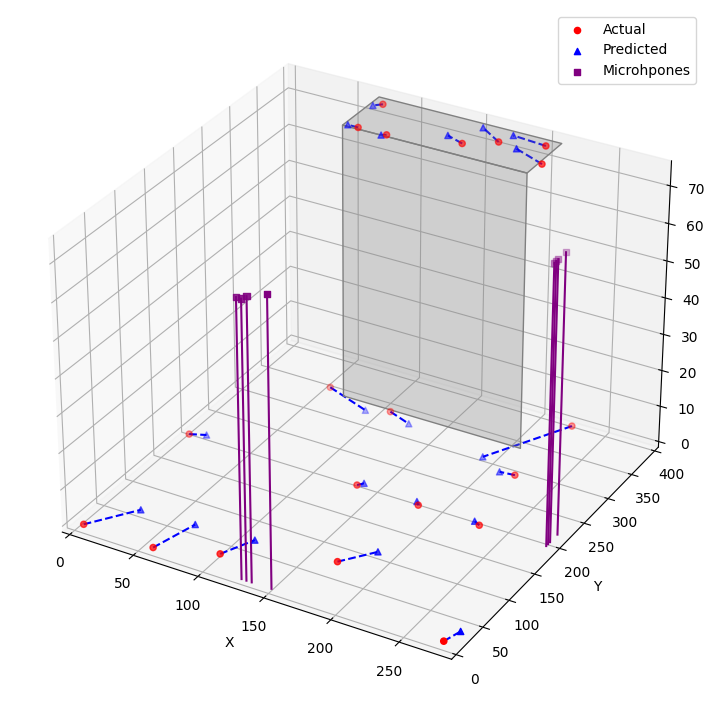

-----------
Actual: (5, 5, 0)
Predicted (28, 53, 0)
-----------
Actual: (60, 4, 0)
Predicted (69, 57, 0)
-----------
Actual: (102, 26, 0)
Predicted (113, 62, 0)
-----------
Actual: (173, 69, 0)
Predicted (190, 102, 0)
-----------
Actual: (4, 192, 0)
Predicted (15, 199, 0)
-----------
Actual: (137, 193, 0)
Predicted (140, 199, 0)
-----------
Actual: (185, 191, 0)
Predicted (182, 196, 0)
-----------
Actual: (232, 189, 0)
Predicted (227, 193, 0)
-----------
Actual: (56, 338, 0)
Predicted (93, 317, 0)
-----------
Actual: (109, 327, 0)
Predicted (128, 316, 0)
-----------
Actual: (227, 392, 0)
Predicted (193, 298, 0)
-----------
Actual: (223, 284, 0)
Predicted (212, 282, 0)
-----------
Actual: (78, 340, 74)
Predicted (70, 340, 74)
-----------
Actual: (150, 360, 74)
Predicted (136, 368, 74)
-----------
Actual: (210, 360, 74)
Predicted (185, 376, 74)
-----------
Actual: (100, 340, 74)
Predicted (97, 337, 74)
-----------
Actual: (170, 380, 74)
Predicted (151, 399, 74)
-----------
Actual: (75, 3

In [ ]:
print('Results for measured TDOAs:\n', means_pred)

plot_points(actual, predicted, plot_refined=False)

for pos, pred in zip(actual, predicted):
    print('-----------')
    print('Actual:', pos)
    print('Predicted', pred)

In [ ]:
def tdoas_calc_no_error(pos):
    x, y, z = pos
    mic_pos = k1_mic_pos

    distances = []
    for i in range(0, 4):
        distances.append(math.sqrt((x - mic_pos[i][0])**2 + (y - mic_pos[i][1])**2 + (z - mic_pos[i][2])**2))

    toas = []
    for i in range(0, 4):
        toas.append(distances[i] / 34300)

    cal_tdoas = {
        'tdoa01': [toas[0] - toas[1]],
        'tdoa02': [toas[0] - toas[2]],
        'tdoa03': [toas[0] - toas[3]],
        'tdoa12': [toas[1] - toas[2]],
        'tdoa13': [toas[1] - toas[3]],
        'tdoa23': [toas[2] - toas[3]]
    }
    return cal_tdoas

In [ ]:
for pos, pred, ref in zip(actual, predicted, refined):
    pred_tdoas = tdoas_calc_no_error(pred)
    ref_tdoas = tdoas_calc_no_error(ref)
    actual_values, tdoa_error = tdoas_calc(pos, pred_tdoas)
    _, tdoa_error_sec = tdoas_calc(pos, ref_tdoas)
    print('Actual Position:', pos)
    print('Ordinary Prediction:', pred)
    print('Refined Prediction:', ref)
    print('Actual TDOAs:', actual_values)
    print('Measured TDOAs:', pred_tdoas)
    print('Estimated TDOAs:', ref_tdoas)
    print(f'TDOA Error between measured and actual: {tdoa_error:.16f}')
    print(f'TDOA Error between refined and actual:  {tdoa_error_sec:.16f}')
    print('------------------------\n')

Actual Position: (4, 192, 0)
Ordinary Prediction: (27, 179, 0)
Refined Prediction: (68, 89, 0)
Actual TDOAs: {'tdoa01': [0.0002624367984765102], 'tdoa02': [0.0003340518585464242], 'tdoa03': [0.0003908843560496639], 'tdoa12': [7.161506006991402e-05], 'tdoa13': [0.00012844755757315373], 'tdoa23': [5.683249750323971e-05]}
Measured TDOAs: {'tdoa01': [0.00024453669088082396], 'tdoa02': [0.00031122267880262684], 'tdoa03': [0.00036245961695298336], 'tdoa12': [6.668598792180288e-05], 'tdoa13': [0.0001179229260721594], 'tdoa23': [5.123693815035652e-05]}
Estimated TDOAs: {'tdoa01': [0.0002698478164456855], 'tdoa02': [0.0003445879602873721], 'tdoa03': [0.00039650045844578973], 'tdoa12': [7.474014384168661e-05], 'tdoa13': [0.00012665264200010422], 'tdoa23': [5.191249815841761e-05]}
TDOA Error between measured and actual: 0.0000902032894382
TDOA Error between refined and actual:  0.0000334032207959
------------------------

Actual Position: (56, 338, 0)
Ordinary Prediction: (91, 326, 0)
Refined Pre

### **Results for Sound Source Localization:**

The following results are obtained on the samples located at /content/drive/MyDrive/Taarlab/Classical/Main/Datasetnew/Samples.

Note that the refinement model was trained on the same samples that were used for prediction and their results are shown below. Thus, these results may not contain the most validity and the more reliable results will be the ones run on new upcoming samples. The samples used right now will be also fed to the surface prediction model to be used in the training process for surface prediction in order to enhance surface prediction results.

Anyhow, below are the results run on current samples:

**Localization Error without Refinement, without Surface Classification:**
* mean error on x axis: 11.2 centimeters
* mean error on y axis: 45.06 centimeters
* mean error on z axis: 16.7 centimeters
* mean of total error:  53.8 centimeters

**Localization Error with Refinement, without Surface Classification:**
* mean error on x axis: 5.4 centimeters
* mean error on y axis: 26.7 centimeters
* mean error on z axis: 11.9 centimeters
* mean of total error:  33.9 centimeters

Below is the obtanied predictions along with the actual source location. The figure also contains the prediction after applying TDOA refinement:

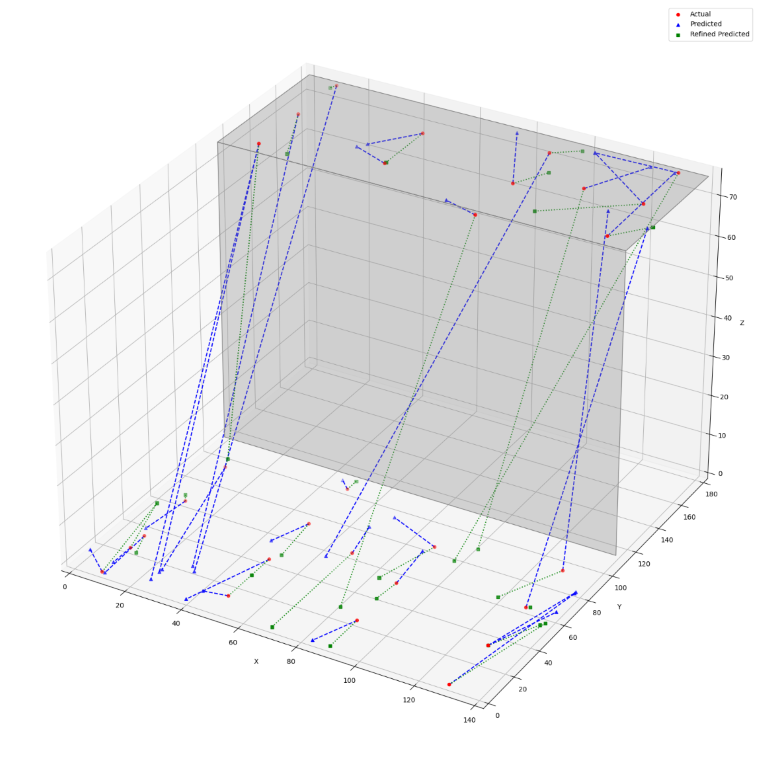

## **Z**

In [ ]:
surface = predict_new_audio_surface(sample_path, model, scaler, label_encoder)
print(f"The predicted label for the new audio file is: {surface}")

z_val = 0
if surface == 'Table' or surface == 'Box':
    z_val = 74

print('Valid Z:', z_val)

/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:172: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-87-042a42702de6>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(path)


The predicted label for the new audio file is: Table
Valid Z: 74


## **HeatMap**

Probable Locations: (array([22]), array([98]))


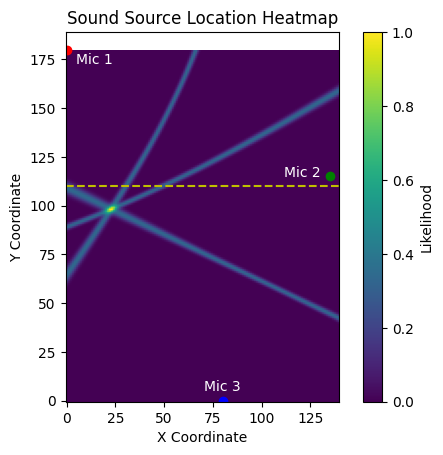

In [ ]:
y_min = 0
y_max = 180
x_min = 0
x_max = 140
grid_resolution = 1
heatmap = np.zeros((int((y_max - y_min)/grid_resolution), int((x_max - x_min)/grid_resolution)))

# sigma value in guassian distribution
sigma = 0.005

# Envalueing the 2D grids cell
for y in np.arange(y_min, y_max, grid_resolution):
    for x in np.arange(x_min, x_max, grid_resolution):
            # Initialize a variable to accumulate likelihood for the current grid point
            likelihood = 0

            # Calculate distances from the grid point to each microphone
            d1 = np.sqrt((x - x0)**2 + (y - y0)**2)
            d2 = np.sqrt((x - x1)**2 + (y - y1)**2)
            d3 = np.sqrt((x - x2)**2 + (y - y2)**2)

            # Calculate expected TDOA based on these distances
            expected_tau_01 = (d1 - d2) / speed
            expected_tau_02 = (d1 - d3) / speed
            expected_tau_12 = (d2 - d3) / speed

            # Compare the expected TDOAs with the measured TDOAs
            # Update the likelihood of the sound source being at the current grid point
            likelihood += np.exp((-(tdoa01 - expected_tau_01)**2) / (2 * sigma**2))
            likelihood += np.exp((-(tdoa02 - expected_tau_02)**2) / (2 * sigma**2))
            likelihood += np.exp((-(tdoa12 - expected_tau_12)**2) / (2 * sigma**2))
            # Store the likelihood in the heatmap array
            heatmap[y][x] = likelihood

# Normalizing the heatmap values
(y, x) = np.where(heatmap == np.max(heatmap))
# most probable coordinates
print('Probable Locations:', (x, y))

heatmap = heatmap / np.max(heatmap)

x_coords = np.arange(x_min, x_max, grid_resolution)
y_coords = np.arange(y_min, y_max, grid_resolution)

# Plot the heatmap
plt.imshow(heatmap, origin='lower')
plt.axhline(y = 110, color = 'y', linestyle = '--')
plt.colorbar(label='Likelihood')
plt.scatter(x0, y0, color='r')
plt.scatter(x1, y1, color='g')
plt.scatter(x2, y2, color='b')
plt.annotate('Mic 1', (x0, y0), textcoords="offset points", xytext=(20,-10), ha='center', color='w')
plt.annotate('Mic 2', (x1, y1), textcoords="offset points", xytext=(-20,0), ha='center', color='w')
plt.annotate('Mic 3', (x2, y2), textcoords="offset points", xytext=(0,7), ha='center', color='w')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sound Source Location Heatmap')
plt.show()

## **2D Heatmap for Kinnect**

{'tdoa01': -6.25e-06, 'tdoa02': -6.25e-06, 'tdoa03': -6.25e-06, 'tdoa12': 6.25e-06, 'tdoa13': 6.25e-06, 'tdoa23': 1.25e-05}
Probable Location: (67, 179)


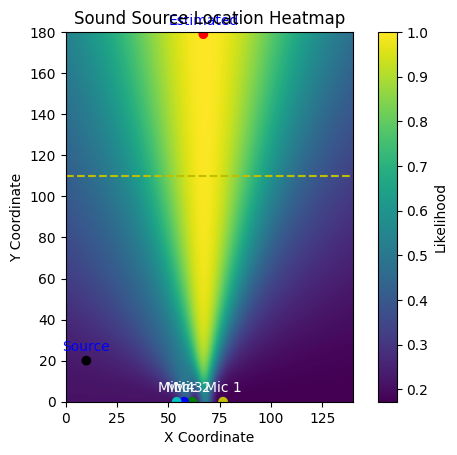

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Room dimensions and grid resolution
y_min = 0
y_max = 180
x_min = 0
x_max = 140
grid_resolution = 1
heatmap = np.zeros((int((y_max - y_min)/grid_resolution), int((x_max - x_min)/grid_resolution)))

# Microphone positions
y0 = y1 = y2 = y3 = 0
x0, x1, x2, x3 = [76.6, 61.7, 57.7, 54]

# Speed of sound
speed = 34300.0

# Actual source value
act_source = (10, 20)

# TDOA values
# tdoas_to_use = tdoas_act
tdoas_to_use = tdoas
print(tdoas_to_use)

# Sigma value in Gaussian distribution
sigma = 0.0001

# Evaluating the 2D grid cells
for y in np.arange(y_min, y_max, grid_resolution):
    for x in np.arange(x_min, x_max, grid_resolution):
        # Initialize a variable to accumulate likelihood for the current grid point
        likelihood = 0

        # Calculate distances from the grid point to each microphone
        d1 = np.sqrt((x - x0)**2 + (y - y0)**2)
        d2 = np.sqrt((x - x1)**2 + (y - y1)**2)
        d3 = np.sqrt((x - x2)**2 + (y - y2)**2)
        d4 = np.sqrt((x - x3)**2 + (y - y3)**2)

        # Calculate expected TDOA based on these distances
        expected_tau_01 = (d1 - d2) / speed
        expected_tau_02 = (d1 - d3) / speed
        expected_tau_03 = (d1 - d4) / speed
        expected_tau_12 = (d2 - d3) / speed
        expected_tau_13 = (d2 - d4) / speed
        expected_tau_23 = (d3 - d4) / speed

        # Compare the expected TDOAs with the measured TDOAs and update the likelihood
        likelihood += np.exp((-(tdoas_to_use['tdoa01'] - expected_tau_01)**2) / (2 * sigma**2))
        likelihood += np.exp((-(tdoas_to_use['tdoa02'] - expected_tau_02)**2) / (2 * sigma**2))
        likelihood += np.exp((-(tdoas_to_use['tdoa03'] - expected_tau_03)**2) / (2 * sigma**2))
        likelihood += np.exp((-(tdoas_to_use['tdoa12'] - expected_tau_12)**2) / (2 * sigma**2))
        likelihood += np.exp((-(tdoas_to_use['tdoa13'] - expected_tau_13)**2) / (2 * sigma**2))
        likelihood += np.exp((-(tdoas_to_use['tdoa23'] - expected_tau_23)**2) / (2 * sigma**2))

        # Store the likelihood in the heatmap array
        heatmap[int((y - y_min)/grid_resolution)][int((x - x_min)/grid_resolution)] = likelihood

# Normalizing the heatmap values
(y, x) = np.unravel_index(np.argmax(heatmap), heatmap.shape)
# Most probable coordinates
print('Probable Location:', (x, y))

heatmap = heatmap / np.max(heatmap)

x_coords = np.arange(x_min, x_max, grid_resolution)
y_coords = np.arange(y_min, y_max, grid_resolution)

# Plot the heatmap
plt.imshow(heatmap, origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.axhline(y = 110, color = 'y', linestyle = '--')
plt.colorbar(label='Likelihood')
plt.scatter([x0, x1, x2, x3, x, act_source[0]], [y0, y1, y2, y3, y, act_source[1]], color=['y', 'g', 'b', 'c', 'r', 'black'])
plt.annotate('Mic 1', (x0, y0), textcoords="offset points", xytext=(0, 7), ha='center', color='w')
plt.annotate('Mic 2', (x1, y1), textcoords="offset points", xytext=(0, 7), ha='center', color='w')
plt.annotate('Mic 3', (x2, y2), textcoords="offset points", xytext=(0, 7), ha='center', color='w')
plt.annotate('Mic 4', (x3, y3), textcoords="offset points", xytext=(0, 7), ha='center', color='w')
plt.annotate('Estimated', (x, y), textcoords="offset points", xytext=(0, 7), ha='center', color='b')
plt.annotate('Source', act_source, textcoords="offset points", xytext=(0, 7), ha='center', color='b')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sound Source Location Heatmap')
plt.show()


In [ ]:
import math

error = math.sqrt((act_source[0] - x)**2 + (act_source[1] - y)**2)
print('Error:', error)

Error: 68.73136110975832


# **Inventory**

## **3D visualization**

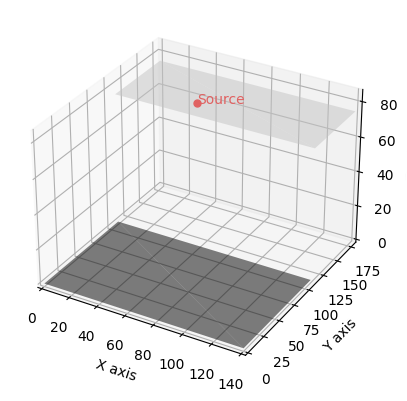

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Create a new figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Dimensions of the environment
x_dim = 140
y_dim = 180
z_table_height = 75
table_start_y = 110

# Ground
ground_x = [0, x_dim, x_dim, 0]
ground_y = [0, 0, table_start_y, table_start_y]
ground_z = [0, 0, 0, 0]

# Table
table_x = [0, x_dim, x_dim, 0]
table_y = [table_start_y, table_start_y, y_dim, y_dim]
table_z = [z_table_height, z_table_height, z_table_height, z_table_height]

# Scatter the point
ax.scatter(50, 130, 75, c='r', marker='.', s=100)
ax.text(50, 130, 75, 'Source', color='red')

# Plot ground
ax.plot_trisurf(ground_x, ground_y, ground_z, color='black', alpha=0.5)

# Plot table
ax.plot_trisurf(table_x, table_y, table_z, color='white', alpha=0.5)

# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Set limits
ax.set_xlim(0, x_dim)
ax.set_ylim(0, y_dim)
ax.set_zlim(0, z_table_height + 10)

# Show plot
plt.show()

## **Multilateration**

In [ ]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [ ]:
# measuerments of the coordinates of the microphones
measurements = [
    [71.6, 0.0],
    [61.7, 0.0],
    [57.7, 0.0],
    [54, 0.0]
]

# speed of sound
speed = 34300.0 # cm

In [ ]:
# function to calculate the hyperboles of each microphone
def hyperbolas(x0, y0, x1, y1, x2, y2, d01, d02, d12):
    def fn(args):
        x, y = args
        a = np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d01
        b = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d02
        c = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - d12
        return [a, b, c]
    return fn

In [ ]:
# Function to calculate the jacobian of the hyperboles equations
def jacobian(x0, y0, x1, y1, x2, y2, d01, d12, d23):
    def fn(args):
        x, y = args
        adx = (x - x1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - (x - x0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        bdx = (x - x2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (x - x0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        cdx = (x - x2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (x - x1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))
        ady = (y - y1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - (y - y0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        bdy = (y - y2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (y - y0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        cdy = (y - y2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (y - y1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))

        return [
            [adx, ady],
            [bdx, bdy],
            [cdx, cdy]
        ]
    return fn

In [ ]:
# Extract measurements
x0, y0 = measurements[0]
x1, y1 = measurements[1]
x2, y2 = measurements[2]
x3, y3 = measurements[3]

# Compute TDOA in terms of distance (m) using the speed of sound
t01 = abs(tdoa01)
t02 = abs(tdoa02)
t12 = abs(tdoa12)

# Function and Jacobian for least squares
F = hyperbolas(x0, y0, x1, y1, x2, y2, t01 * speed, t02 * speed, t12 * speed)
J = jacobian(x0, y0, x1, y1, x2, y2, t01 * speed, t02 * speed, t12 * speed)


In [ ]:
from scipy.optimize import Bounds

# Initial guess for the source location (mean of the measurement points)
xp = np.mean([x for x, y, in measurements])
yp = np.mean([y for x, y, in measurements])

# Perform least squares optimization
result = opt.least_squares(F, x0=[xp, yp], jac=J, bounds=([0, 0], [140, 180]))
x, y = result.x

In [ ]:
print(f"Estimated source location: ({x}, {y})")

Estimated source location: (38.04326503110371, 138.95083173400022)


In [ ]:
# Function to calculate the hyperboles of each microphone
def hyperbolas(x0, y0, x1, y1, x2, y2, x3, y3, d01, d02, d03, d12, d13, d23):
    def fn(args):
        x, y = args
        a = np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d01
        b = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d02
        c = np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.)) - d03
        d = np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - d12
        e = np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - d13
        f = np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - d23
        return [a, b, c, d, e, f]
    return fn

# Function to calculate the jacobian of the hyperboles equations
def jacobian(x0, y0, x1, y1, x2, y2, x3, y3, d01, d02, d03, d12, d13, d23):
    def fn(args):
        x, y = args
        adx = (x - x1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - (x - x0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        bdx = (x - x2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (x - x0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        cdx = (x - x3) / np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - (x - x0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        ddx = (x - x2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (x - x1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))
        edx = (x - x3) / np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - (x - x1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))
        fdx = (x - x3) / np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - (x - x2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.))
        ady = (y - y1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.)) - (y - y0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        bdy = (y - y2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (y - y0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        cdy = (y - y3) / np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - (y - y0) / np.sqrt(np.power(x - x0, 2.) + np.power(y - y0, 2.))
        ddy = (y - y2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.)) - (y - y1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))
        edy = (y - y3) / np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - (y - y1) / np.sqrt(np.power(x - x1, 2.) + np.power(y - y1, 2.))
        fdy = (y - y3) / np.sqrt(np.power(x - x3, 2.) + np.power(y - y3, 2.)) - (y - y2) / np.sqrt(np.power(x - x2, 2.) + np.power(y - y2, 2.))

        return [
            [adx, ady],
            [bdx, bdy],
            [cdx, cdy],
            [ddx, ddy],
            [edx, edy],
            [fdx, fdy]
        ]
    return fn

# Extract measurements
x0, y0 = measurements[0]
x1, y1 = measurements[1]
x2, y2 = measurements[2]
x3, y3 = measurements[3]

# Compute TDOA in terms of distance (m) using the speed of sound
tdoa_to_use = tdoas
# tdoa_to_use = tdoas_act

t01 = tdoa_to_use['tdoa01']
t02 = tdoa_to_use['tdoa02']
t03 = tdoa_to_use['tdoa03']
t12 = tdoa_to_use['tdoa12']
t13 = tdoa_to_use['tdoa13']
t23 = tdoa_to_use['tdoa23']

# Function and Jacobian for least squares
F = hyperbolas(x0, y0, x1, y1, x2, y2, x3, y3, t01 * speed, t02 * speed, t03 * speed, t12 * speed, t13 * speed, t23 * speed)
J = jacobian(x0, y0, x1, y1, x2, y2, x3, y3, t01 * speed, t02 * speed, t03 * speed, t12 * speed, t13 * speed, t23 * speed)

# Initial guess for the source location (mean of the measurement points)
xp = np.mean([x for x, y, in measurements])
yp = np.mean([y for x, y, in measurements])

# Perform least squares optimization
result = opt.least_squares(F, x0=[xp, yp], jac=J, bounds=([0, 0], [140, 180]))
x, y = result.x

print(f"Estimated source location: ({x}, {y})")


Estimated source location: (139.99999999999997, 61.922756949540755)


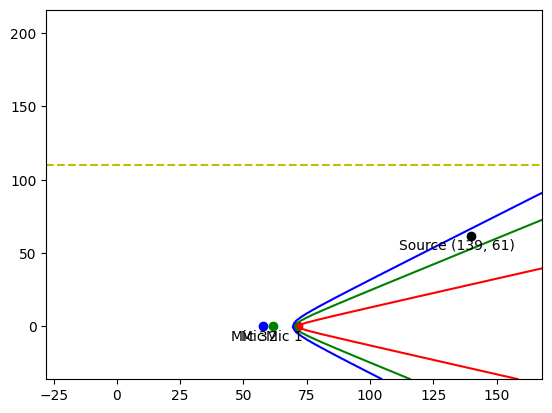

In [ ]:
# Create reasonable x, y bounds for visualization
max_x = 140
min_x = 0
range_x = max_x - min_x
min_x -= range_x * .2
max_x += range_x * .2

max_y = 180
min_y = 0
range_y = max_y - min_y
min_y -= range_y * .2
max_y += range_y * .2

# Create a grid of input coordinates
xs = np.linspace(min_x, max_x, 100)
ys = np.linspace(min_y, max_y, 100)
xs, ys = np.meshgrid(xs, ys)

# Evaluate the system across the grid
A, B, C, D, E, F = F((xs, ys))

# Plot the results
plt.scatter(x0, y0, color='r')
plt.scatter(x1, y1, color='g')
plt.scatter(x2, y2, color='b')
plt.scatter(x, y, color='k')
plt.annotate('Mic 1', (x0, y0), textcoords="offset points", xytext=(-10,-10), ha='center')
plt.annotate('Mic 2', (x1, y1), textcoords="offset points", xytext=(-10,-10), ha='center')
plt.annotate('Mic 3', (x2, y2), textcoords="offset points", xytext=(-10,-10), ha='center')
plt.annotate('Source (' + str(int(x)) + ', ' + str(int(y)) + ')', (x, y), textcoords="offset points", xytext=(-10,-10), ha='center')
plt.axhline(y = 110, color = 'y', linestyle = '--')
plt.contour(xs, ys, A, [0], colors='r')
plt.contour(xs, ys, B, [0], colors='g')
plt.contour(xs, ys, C, [0], colors='b')
plt.show()

## **Alternative Approach**

In [ ]:
!pip install localization

In [ ]:
import localization as lx

P = lx.Project(mode='2D',solver='LSE_GC')

P.add_anchor('anchore_A',(0,180))
P.add_anchor('anchore_B',(135,115))
P.add_anchor('anchore_C',(80,0))

t,label = P.add_target()

t.add_measure('anchore_A', 65.03)
t.add_measure('anchore_B', 60.53)
t.add_measure('anchore_C', 67.06)

P.solve()
print(t.loc)

GC-LSE geolocating...
t1 could not be localized by LSE_GC
None


## **Extras**

In [ ]:
from scipy.signal import find_peaks

def gcc_phat_multi(sig, refsig, fs=1, max_tau=None, interp=10, num_peaks=3):

    n = sig.shape[0] + refsig.shape[0]

    # FFT of the two signals
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)

    # GCC-PHAT
    R = SIG * np.conj(REFSIG)
    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # Find multiple peaks
    peaks, _ = find_peaks(np.abs(cc), distance=interp)
    sorted_peaks = np.argsort(np.abs(cc[peaks]))[::-1]  # Sort peaks by magnitude
    top_peaks = sorted_peaks[:num_peaks]  # Select the top `num_peaks` peaks

    taus = [(peaks[p] - max_shift) / float(interp * fs) for p in top_peaks]

    return taus, cc

In [ ]:
import numpy as np

def find_max_index(signal, num = 1):
    signal_cop = signal
    signal_cop = np.sort(signal_cop)
    max = signal_cop[signal_cop.shape[0] - num]
    return np.where(signal == max)

In [ ]:
def remove_hand_clap(signal, sr):
    max_val_index = np.argmax(signal)
    start = max_val_index + sr
    return signal[start:]

In [ ]:
def signal_load_and_preprocess_sec(path1, path2, path3):
    sig1, sr1 = librosa.load(path1, sr=None)
    sig2, sr2 = librosa.load(path2, sr=None)
    sig3, sr3 = librosa.load(path3, sr=None)

    sr = sr3
    sig1 = librosa.resample(sig2, orig_sr=sr1, target_sr=sr)
    sig2 = librosa.resample(sig3, orig_sr=sr2, target_sr=sr)

    sig1 = remove_hand_clap(sig1, sr)
    sig2 = remove_hand_clap(sig2, sr)
    sig3 = remove_hand_clap(sig3, sr)

    min_shape = min(sig1.shape[0], sig2.shape[0], sig3.shape[0])
    sig1 = sig1[:min_shape]
    sig2 = sig2[:min_shape]
    sig3 = sig3[:min_shape]

    print('-->Load & Preprocessing Done.')
    return sig1, sig2, sig3, sr

In [ ]:
def raw_load(path1, path2, path3):
    sig1, sr1 = librosa.load(path1, sr=None)
    sig2, sr2 = librosa.load(path2, sr=None)
    sig3, sr3 = librosa.load(path3, sr=None)

    sr = sr3
    sig1 = librosa.resample(sig2, orig_sr=sr1, target_sr=sr)
    sig2 = librosa.resample(sig3, orig_sr=sr2, target_sr=sr)

    min_shape = min(sig1.shape[0], sig2.shape[0], sig3.shape[0])
    sig1 = sig1[:min_shape]
    sig2 = sig2[:min_shape]
    sig3 = sig3[:min_shape]

    print('-->Raw laod Done.')
    return sig1, sig2, sig3, sr

## **Extra**

Probable Location: (58, 179)


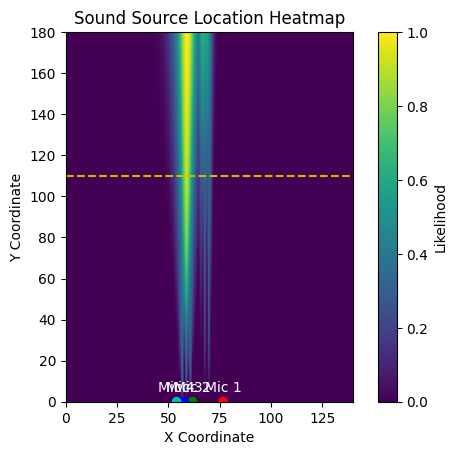

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Room dimensions and grid resolution
z_min = 0
z_max = 75
y_min = 0
y_max = 180
x_min = 0
x_max = 140
grid_resolution = 1
heatmap = np.zeros((int((y_max - y_min) / grid_resolution), int((x_max - x_min) / grid_resolution)))

# Microphone positions in 3D
mics = np.array([
    [76.6, 0, 75],
    [61.7, 0, 75],
    [57.7, 0, 75],
    [54, 0, 75]
])

# Speed of sound
speed = 343.0

# TDOA values (replace these with your actual measured TDOA values)
tdoas = {
    'tdoa01': tdoa01,
    'tdoa02': tdoa02,
    'tdoa03': tdoa03,
    'tdoa12': tdoa12,
    'tdoa13': tdoa13,
    'tdoa23': tdoa23
}

# Sigma value in Gaussian distribution
sigma = 0.0003

# Evaluating the 2D grid cells
for y in np.arange(y_min, y_max, grid_resolution):
    for x in np.arange(x_min, x_max, grid_resolution):
        for z in np.arange(z_min, z_max, grid_resolution):
            # Initialize a variable to accumulate likelihood for the current grid point
            likelihood = 0
            # Calculate distances from the grid point to each microphone
            distances = np.linalg.norm(mics - np.array([x, y, z]), axis=1)
            # Calculate expected TDOA based on these distances
            expected_tdoas = {
                'tdoa01': (distances[0] - distances[1]) / speed,
                'tdoa02': (distances[0] - distances[2]) / speed,
                'tdoa03': (distances[0] - distances[3]) / speed,
                'tdoa12': (distances[1] - distances[2]) / speed,
                'tdoa13': (distances[1] - distances[3]) / speed,
                'tdoa23': (distances[2] - distances[3]) / speed
            }
            # Compare the expected TDOAs with the measured TDOAs and update the likelihood
            for key in tdoas:
                likelihood += np.exp(-((tdoas[key] - expected_tdoas[key])**2) / (2 * sigma**2))

        # Store the likelihood in the heatmap array
        heatmap[int((y - y_min) / grid_resolution)][int((x - x_min) / grid_resolution)] = likelihood

# Normalizing the heatmap values
(y, x) = np.unravel_index(np.argmax(heatmap), heatmap.shape)
# Most probable coordinates
print('Probable Location:', (x, y))

heatmap = heatmap / np.max(heatmap)

x_coords = np.arange(x_min, x_max, grid_resolution)
y_coords = np.arange(y_min, y_max, grid_resolution)

# Plot the heatmap
plt.imshow(heatmap, origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.axhline(y=110, color='y', linestyle='--')
plt.colorbar(label='Likelihood')
plt.scatter(mics[:, 0], mics[:, 1], color=['r', 'g', 'b', 'c'])
for i, mic in enumerate(mics):
    plt.annotate(f'Mic {i+1}', (mic[0], mic[1]), textcoords="offset points", xytext=(0, 7), ha='center', color='w')
plt.annotate('Source', (x, y), textcoords="offset points", xytext=(0, 7), ha='center', color='w')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sound Source Location Heatmap')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_points_3D():
    # Example lists of positions
    # actual_positions = positions
    # predicted_positions = predicted
    # refined_predicted_positions = refined

    # mic positions
    mic_xs = [76.6, 61.7, 57.7, 54]
    mic_ys = [0, 0, 0, 0]
    mic_zs = [74, 74, 74, 74]

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Unpack the positions for plotting
    actual_x, actual_y, actual_z = zip(*actual_positions)
    predicted_x, predicted_y, predicted_z = zip(*predicted_positions)
    refined_x, refined_y, refined_z = zip(*refined_predicted_positions)

    # Plot the points
    ax.scatter(actual_x, actual_y, actual_z, c='r', marker='o', label='Actual')
    ax.scatter(predicted_x, predicted_y, predicted_z, c='b', marker='^', label='Predicted')
    if plot_refined:
        ax.scatter(refined_x, refined_y, refined_z, c='g', marker='s', label='Refined Predicted')

    # Plot microphone points
    # ax.scatter(mic_xs, mic_ys, mic_zs, marker='1', c='purple', label='Microhpones')

    # Connect the actual points to predicted and refined predicted points
    for i in range(len(actual_positions)):
        ax.plot([actual_x[i], predicted_x[i]], [actual_y[i], predicted_y[i]], [actual_z[i], predicted_z[i]], c='b', linestyle='dashed')
        if plot_refined:
            ax.plot([actual_x[i], refined_x[i]], [actual_y[i], refined_y[i]], [actual_z[i], refined_z[i]], c='g', linestyle='dotted')

    # Set grid dimensions
    ax.set_xlim([0, 140])
    ax.set_ylim([0, 180])
    ax.set_zlim([0, 75])

    # Highlight the table range horizontally with 3D polygons
    table_y_min = 110
    table_y_max = 180
    table_vertices = [
        [(0, table_y_min, 0), (140, table_y_min, 0), (140, table_y_min, 75), (0, table_y_min, 75)],
        [(0, table_y_min, 75), (140, table_y_min, 75), (140, table_y_max, 75), (0, table_y_max, 75)]
    ]


    ax.add_collection3d(Poly3DCollection(table_vertices, color='gray', alpha=0.3))

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

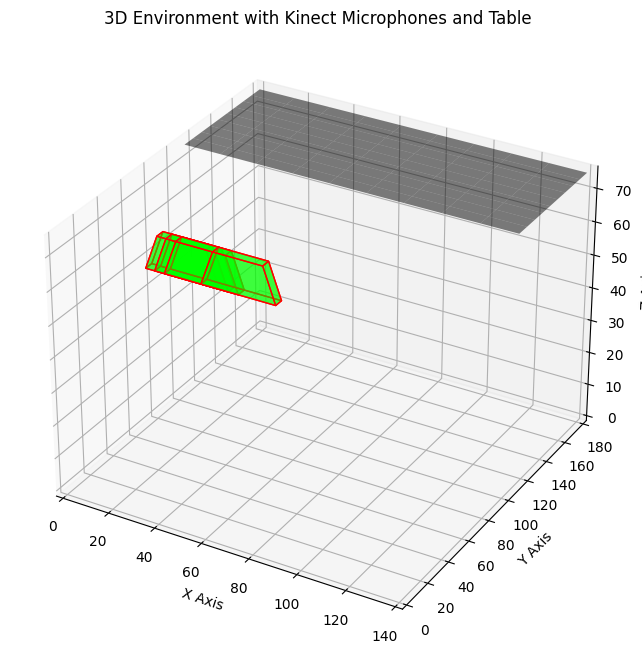

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Environment dimensions
env_x, env_y, env_z = 140, 180, 75

# Kinect microphone positions (replace with actual positions)
# Example positions: [(x1, y1, z1), (x2, y2, z2), ...]
kinect_positions = [
    [76.6, 0, 75],
    [61.7, 0, 75],
    [57.7, 0, 75],
    [54, 0, 75]
]

# Table dimensions and position
table_start_y = 110
table_end_y = env_y
table_x = np.linspace(0, env_x, 10)
table_y = np.linspace(table_start_y, table_end_y, 10)
table_z = np.ones_like(table_x)
table_z = 75

# Kinect dimensions (replace with actual dimensions)
kinect_width_top = 20
kinect_width_bottom = 30
kinect_height = 10
kinect_depth = 5

def plot_kinect(ax, center_x, center_y, center_z, width_top, width_bottom, height, depth):
    # Calculate the coordinates of the vertices
    half_width_top = width_top / 2
    half_width_bottom = width_bottom / 2
    half_depth = depth / 2

    # Top face vertices
    top_front_left = [center_x - half_width_top, center_y + half_depth, center_z + height]
    top_front_right = [center_x + half_width_top, center_y + half_depth, center_z + height]
    top_back_left = [center_x - half_width_top, center_y - half_depth, center_z + height]
    top_back_right = [center_x + half_width_top, center_y - half_depth, center_z + height]

    # Bottom face vertices
    bottom_front_left = [center_x - half_width_bottom, center_y + half_depth, center_z]
    bottom_front_right = [center_x + half_width_bottom, center_y + half_depth, center_z]
    bottom_back_left = [center_x - half_width_bottom, center_y - half_depth, center_z]
    bottom_back_right = [center_x + half_width_bottom, center_y - half_depth, center_z]

    # Define the vertices for the trapezoid
    vertices = [
        [top_front_left, top_front_right, bottom_front_right, bottom_front_left],  # Front face
        [top_back_left, top_back_right, bottom_back_right, bottom_back_left],  # Back face
        [top_front_left, top_back_left, bottom_back_left, bottom_front_left],  # Left face
        [top_front_right, top_back_right, bottom_back_right, bottom_front_right],  # Right face
        [top_front_left, top_front_right, top_back_right, top_back_left],  # Top face
        [bottom_front_left, bottom_front_right, bottom_back_right, bottom_back_left]  # Bottom face
    ]

    faces = Poly3DCollection(vertices, alpha=0.5, linewidths=1, edgecolors='r')
    faces.set_facecolor((0, 1, 0, 0.5))  # Set face color with transparency
    ax.add_collection3d(faces)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Kinect microphone positions
kinect_positions = np.array(kinect_positions)
for pos in kinect_positions:
    plot_kinect(ax, pos[0], pos[1], pos[2], kinect_width_top, kinect_width_bottom, kinect_height, kinect_depth)

# Plot the table
table_xx, table_yy = np.meshgrid(table_x, table_y)
table_zz = np.ones_like(table_xx)
table_zz *= 75
ax.plot_surface(table_xx, table_yy, table_zz, color='b', alpha=0.5, label='Table')

# Set axis labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Set axis limits
ax.set_xlim(0, env_x)
ax.set_ylim(0, env_y)
ax.set_zlim(0, env_z)

# Set title and legend
ax.set_title('3D Environment with Kinect Microphones and Table')
# plt.legend(['Kinect Microphones', 'Table'])

# Show plot
plt.show()
